
## This notebook shows how to use `grizli` to

retrieve and pre-process raw CLEAR G102/F105W and 3D-HST G141/F140W observations for a single CLEAR pointing (GS1).

These series of notebooks draw heavily from Gabe Brammer's existing `grizli` notebooks, which are available at https://github.com/gbrammer/grizli/tree/master/examples, but with examples specific for the CLEAR survey.

In [1]:
import grizli

try: 
    from mastquery import query, overlaps
    use_mquery = True
except: 
    from hsaquery import query, overlaps
    use_mquery = False

import os
import numpy as np
from IPython.display import Image
from grizli.pipeline import auto_script
import glob
from glob import glob
import astropy
from grizli.prep import process_direct_grism_visit
from astropy.io import fits

<h1><center>Initialize Directories</center></h1>


### ***The following paths need to be changed for your filesystem.*** [HOME_PATH] is where the raw data, reduced data, and `grizli` outputs will be stored. [PATH_TO_CATS] is where the catalogs are stored and must include the following:
        ###     reference mosaic image (e.g., goodss-F105W-astrodrizzle-v4.3_drz_sci.fits)
        ###     segmentation map       (e.g., Goods_S_plus_seg.fits)
        ###     source catalog         (e.g., goodss-F105W-astrodrizzle-v4.3_drz_sub_plus.cat)
        ###     radec_catalog          (e.g., goodsS_radec.cat)
        ###     3DHST Eazy Catalogs    (e.g., goodss_3dhst.v4.1.cats/*)
        
the [PATH_TO_CATS] files are available on the team archive: https://archive.stsci.edu/pub/clear_team/INCOMING/for_hackday/

In [2]:
field           = 'GS1'
ref_filter      = 'F105W'

HOME_PATH       = '/Users/rsimons/Desktop/clear/for_hackday/%s'%field
PATH_TO_CATS    = '/Users/rsimons/Desktop/clear/Catalogs'

# Create [HOME_PATH] and [HOME_PATH]/query_results directories if they do not already exist
if not os.path.isdir(HOME_PATH): os.system('mkdir %s'%HOME_PATH)
if not os.path.isdir(HOME_PATH + '/query_results'): os.system('mkdir %s/query_results'%HOME_PATH)

# Move to the [HOME_PATH] directory
os.chdir(HOME_PATH)


<h1><center>Query MAST</center></h1>

### Run an initial query for all raw G102 data in the MAST archive from the proposal ID 14227 with a target name that includes the phrase 'GS1' (i.e., GS1 pointing of CLEAR). 

In [3]:
# proposal_id = [14227] is CLEAR
parent = query.run_query(box = None, proposal_id = [14227], instruments=['WFC3/IR', 'ACS/WFC'], 
                         filters = ['G102'], target_name = 'GS1')

### Next, find all G102 and G141 observations that overlap with the pointings found in the initial query.

Iter #1, N_Patch = 1


 0 j0333m2742 53.24696550387 -27.69263492857333
 target_name 
-------------
GOODS-SOUTH-1
          GS1 

filter j0333m2742          WFC3/IR G102    6   27670.5
filter j0333m2742          WFC3/IR G141    1    4711.7


0

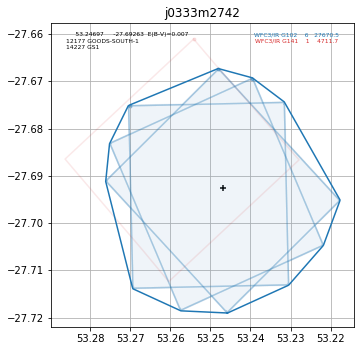

In [4]:
# Find all G102 and G141 observations overlapping the parent query in the archive
tabs = overlaps.find_overlaps(parent, buffer_arcmin=0.01, 
                              filters=['G102', 'G141'], 
                              instruments=['WFC3/IR','WFC3/UVIS','ACS/WFC'], close=False)

footprint_fits_file = glob('*footprint.fits')[0]
jtargname = footprint_fits_file.strip('_footprint.fits')


# A list of the target names
fp_fits = fits.open(footprint_fits_file)
overlapping_target_names = set(fp_fits[1].data['target'])


# Move the footprint figure files to $HOME_PATH/query_results/ so that they are not overwritten
os.system('cp %s/%s_footprint.fits %s/query_results/%s_footprint_%s.fits'%(HOME_PATH, jtargname, HOME_PATH, jtargname, 'all_G102_G141'))
os.system('cp %s/%s_footprint.npy %s/query_results/%s_footprint_%s.npy'%(HOME_PATH, jtargname, HOME_PATH, jtargname,  'all_G102_G141'))
os.system('cp %s/%s_footprint.pdf %s/query_results/%s_footprint_%s.pdf'%(HOME_PATH, jtargname, HOME_PATH, jtargname,  'all_G102_G141'))
os.system('cp %s/%s_info.dat %s/query_results/%s_info_%s.dat'%(HOME_PATH, jtargname, HOME_PATH, jtargname,  'all_G102_G141'))


In [5]:
# Table summary of query
tabs[0]

dataproduct_type,calib_level,obs_collection,obs_id,target,ra,dec,t_min,t_max,exptime,wavelength_region,filter,em_min,em_max,target_classification,obs_title,t_obs_release,instrument_name,proposal_pi,proposal_id,proposal_type,project,sequence_number,footprint,jpegURL,dataURL,dataRights,mtFlag,srcDen,intentType,obsid,objID,objID1,distance,visit,area
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,arcmin2
str5,int64,str3,str9,str13,float64,float64,float64,float64,float64,str8,str4,float64,float64,str44,str67,float64,str7,str18,str5,str2,str3,int64,str377,str34,str35,str6,bool,float64,str7,str10,str10,str10,float64,str2,float64
image,3,HST,ibhj01040,GOODS-SOUTH-1,53.255415,-27.687389,55892.9085,55892.7029,4711.7,Infrared,G141,2010000000000.0,810.0,GALAXY;HIGH REDSHIFT GALAXY,3D-HST: A Spectroscopic Galaxy Evolution Treasury,55892.98569,WFC3/IR,"van Dokkum, Pieter",12177,GO,HST,--,POLYGON 53.254169 -27.66103 53.248983469105383 -27.666196765263123 53.22788095 -27.68661379 53.26037798 -27.71237722 53.26669195893993 -27.705915869534575 53.286238 -27.686438 53.254169 -27.66103 53.254169 -27.66103,mast:HST/product/ibhj01040_drz.jpg,mast:HST/product/ibhj01040_drz.fits,PUBLIC,False,--,science,2003845106,2019997677,2019997677,0.0,01,4.8
image,3,HST,icxt07020,GS1,53.246769,-27.692739,57409.5205,57409.4271,4611.7,Infrared,G102,1275.0,775.0,UNIDENTIFIED;BLANK FIELD;HIGH LATITUDE FIELD,The CANDELS Lyman-alpha Emission At Reionization (CLEAR) Experiment,57409.83295,WFC3/IR,"Papovich, Casey",14227,GO,HST,--,POLYGON 53.239606 -27.669395 53.239434848857933 -27.669738228485233 53.239313 -27.669691 53.221925 -27.704549 53.22215274210965 -27.704637275844966 53.222093 -27.704757 53.257313 -27.718403 53.257484556792519 -27.718058969306647 53.257606 -27.718106 53.274985 -27.683244 53.274757288789495 -27.683155825049127 53.274817 -27.683036 53.239606 -27.669395 53.239606 -27.669395,--,mast:HST/product/icxt07020_drz.fits,PUBLIC,False,--,science,2004616325,2025691922,2025691922,0.0,07,4.8
image,3,HST,icxt08020,GS1,53.246769,-27.692739,57409.6524,57409.5632,4611.7,Infrared,G102,1275.0,775.0,UNIDENTIFIED;BLANK FIELD;HIGH LATITUDE FIELD,The CANDELS Lyman-alpha Emission At Reionization (CLEAR) Experiment,57410.00059,WFC3/IR,"Papovich, Casey",14227,GO,HST,--,POLYGON 53.239606 -27.669395 53.239434848857933 -27.669738228485233 53.239313 -27.669691 53.221925 -27.704549 53.22215274210965 -27.704637275844966 53.222093 -27.704757 53.257313 -27.718403 53.257484556792519 -27.718058969306647 53.257606 -27.718106 53.274985 -27.683244 53.274757288789495 -27.683155825049127 53.274817 -27.683036 53.239606 -27.669395 53.239606 -27.669395,--,mast:HST/product/icxt08020_drz.fits,PUBLIC,False,--,science,2004616327,2025691174,2025691174,0.0,08,4.8
image,3,HST,icxt09020,GS1,53.248375,-27.693616,57376.6535,57376.5582,4611.7,Infrared,G102,1275.0,775.0,UNIDENTIFIED;BLANK FIELD;HIGH LATITUDE FIELD,The CANDELS Lyman-alpha Emission At Reionization (CLEAR) Experiment,57376.8274,WFC3/IR,"Papovich, Casey",14227,GO,HST,--,POLYGON 53.270118 -27.675168 53.231693 -27.674458 53.231682657086814 -27.674834465912305 53.23155 -27.674832 53.230502 -27.712928 53.230750615552886 -27.712932619689933 53.230747 -27.713064 53.269185 -27.713773 53.2691952035849 -27.713397568887331 53.269328 -27.7134 53.270363 -27.675304 53.270114433397104 -27.675299447777519 53.270118 -27.675168 53.270118 -27.675168,--,mast:HST/product/icxt09020_drz.fits,PUBLIC,False,--,science,2004374626,2025691340,2025691340,0.0,09,4.8
image,3,HST,icxt10020,GS1,53.248375,-27.693616,57409.3218,57409.2285,4611.7,Infrared,G102,1275.0,775.0,UNIDENTIFIED;BLANK FIELD;HIGH LATITUDE FIELD,The CANDELS Lyman-alpha Emission At Reionization (CLEAR) Experiment,57409.57509,WFC3/IR,"Papovich, Casey",14227,GO,HST,--,POLYGON 53.270118 -27.675168 53.231694 -27.674459 53.231683674155349 -27.674834466292776 53.231551 -27.674832 53.230503 -27.712927 53.230751612015055 -27.712931626328988 53.230748 -27.713062999999998 53.269185 -27.713773 53.269195193826761 -27.71339756518

<h1><center>Retrieve raw data from MAST</center></h1>


### We now have a list of G102 and G141 observations in the MAST archive that overlap with the GS1 pointing of CLEAR. 

### For each, retrieve all associated RAW grism G102/G141 and direct imaging F098M/F105W/F125W/F140W data from MAST.

**For GS1, the retrieval step takes about 30 minutes to run and requires 1.9 GB of space.


Iter #1, N_Patch = 1


 0 j0333m2742 53.24696550387 -27.69263492857333
 target_name 
-------------
GOODS-SOUTH-1 

filter j0333m2742         WFC3/IR F140W    1     811.7
filter j0333m2742          WFC3/IR G141    1    4711.7
Iter #1, N_Patch = 1


 0 j0333m2742 53.24696550387 -27.69263492857333
target_name
-----------
        GS1 

filter j0333m2742         WFC3/IR F105W    6    3185.2
filter j0333m2742          WFC3/IR G102    6   27670.5


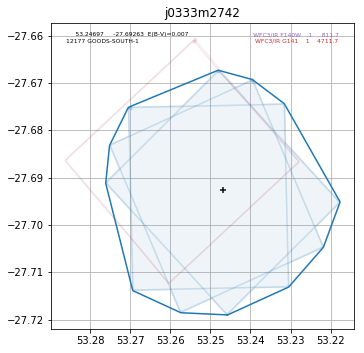

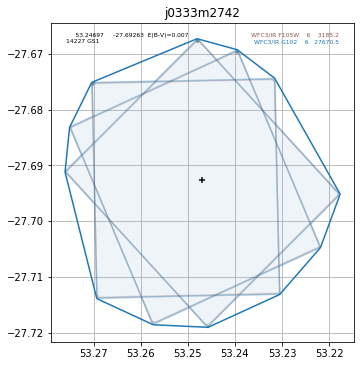

In [6]:
# Loop targ_name by targ_name
for t, targ_name in enumerate(overlapping_target_names):
    if use_mquery:
        extra = {'target_name':targ_name}
    else:
        extra = query.DEFAULT_EXTRA.copy()
        extra += ["TARGET.TARGET_NAME LIKE '%s'"%targ_name]
    
    # search the MAST archive again, this time looking for 
    # all grism and imaging observations with the given target name
    tabs = overlaps.find_overlaps(parent, buffer_arcmin=0.01, 
                                  filters=['G102', 'G141', 'F098M', 'F105W', 'F125W', 'F140W'], 
                                  instruments=['WFC3/IR','WFC3/UVIS','ACS/WFC'], 
                                  extra=extra, close=False)
    if False:
        # retrieve raw data from MAST
        s3_status = os.system('aws s3 ls s3://stpubdata --request-payer requester')
        auto_script.fetch_files(field_root=jtargname, HOME_PATH=HOME_PATH, remove_bad=True, 
                                reprocess_parallel=True, s3_sync=(s3_status == 0))

    # Move the figure files to $HOME_PATH/query_results/ so that they are not overwritten
    os.system('mv %s/%s_footprint.fits %s/query_results/%s_footprint_%s.fits'%(HOME_PATH, jtargname, HOME_PATH, jtargname, targ_name))
    os.system('mv %s/%s_footprint.npy %s/query_results/%s_footprint_%s.npy'%(HOME_PATH, jtargname, HOME_PATH, jtargname, targ_name))
    os.system('mv %s/%s_footprint.pdf %s/query_results/%s_footprint_%s.pdf'%(HOME_PATH, jtargname, HOME_PATH, jtargname, targ_name))
    os.system('mv %s/%s_info.dat %s/query_results/%s_info_%s.dat'%(HOME_PATH, jtargname, HOME_PATH, jtargname, targ_name))

    os.chdir(HOME_PATH)

### The following directories are created from auto_script.fetch_files:
        [HOME_PATH]/j0333m2742
        [HOME_PATH]/j0333m2742/RAW
        [HOME_PATH]/j0333m2742/Prep
        [HOME_PATH]/j0333m2742/Extractions
        [HOME_PATH]/j0333m2742/Persistance
         
        
RAW/ is where the downloaded raw and pre-processed data are stored.

Prep/ is the general working directory for processing and analyses.





In [7]:
PATH_TO_RAW     = glob(HOME_PATH + '/*/RAW')[0]
PATH_TO_PREP    = glob(HOME_PATH + '/*/PREP')[0]

# Move to the Prep directory
os.chdir(PATH_TO_PREP)

Extract exposure information from downloaded flt files

In [8]:
# Find all pre-processed flt files in the RAW directory
files = glob('%s/*flt.fits'%PATH_TO_RAW)
# Generate a table from the headers of the flt fits files
info = grizli.utils.get_flt_info(files)

The ``info`` table includes relevant exposure details: e.g., filter, instrument, targetname, PA, RA, DEC.
    
Print the first three rows of the table.

In [9]:
info[0:3]

FILE,FILTER,INSTRUME,DETECTOR,TARGNAME,DATE-OBS,TIME-OBS,EXPSTART,EXPTIME,PA_V3,RA_TARG,DEC_TARG,POSTARG1,POSTARG2
str18,str5,str4,str2,str13,str10,str8,float64,float64,float64,float64,float64,float64,float64
icxt12quq_flt.fits,F105W,WFC3,IR,GS1,2016-01-28,06:09:43,57415.25674951,302.938477,269.001587,53.25006791667,-27.68959166667,-14.601,-5.077
icxt09ezq_flt.fits,F105W,WFC3,IR,GS1,2015-12-20,13:18:14,57376.55432926,302.938477,226.563293,53.25006791667,-27.68959166667,-14.601,-5.077
ibhj01ivq_flt.fits,F140W,WFC3,IR,GOODS-SOUTH-1,2011-11-27,18:04:31,55892.75314558,202.933945,177.000107,53.257475,-27.68902222222,1.355,0.424


Next, we use `grizli` to parse the headers of the downloaded flt files in RAW/ and sort them into "visits". Each visit represents a specific pointing + orient + filter and contains the list of its associated exposure files.

In [10]:
# Parse the table and group exposures into associated "visits"
visits, filters = grizli.utils.parse_flt_files(info=info, uniquename=True)

# an F140W imaging visit
print ('\n\n visits[0]\n\t product: ', visits[0]['product'], '\n\t files: ', visits[0]['files'])

# a g141 grism visit
print ('\n\n visits[1]\n\t product: ', visits[1]['product'], '\n\t files: ', visits[1]['files'])



goodss-01-bhj-01-177.0-F140W 4
goodss-01-bhj-01-177.0-G141 4
GS1-cxt-09-227.0-F105W 2
GS1-cxt-10-227.0-F105W 2
GS1-cxt-07-249.0-F105W 2
GS1-cxt-08-249.0-F105W 2
GS1-cxt-11-269.0-F105W 2
GS1-cxt-12-269.0-F105W 2
GS1-cxt-09-227.0-G102 4
GS1-cxt-10-227.0-G102 4
GS1-cxt-07-249.0-G102 4
GS1-cxt-08-249.0-G102 4
GS1-cxt-11-269.0-G102 4
GS1-cxt-12-269.0-G102 4


 visits[0]
	 product:  goodss-01-bhj-01-177.0-f140w 
	 files:  ['ibhj01ioq_flt.fits', 'ibhj01ivq_flt.fits', 'ibhj01j2q_flt.fits', 'ibhj01j9q_flt.fits']


 visits[1]
	 product:  goodss-01-bhj-01-177.0-g141 
	 files:  ['ibhj01iqq_flt.fits', 'ibhj01ixq_flt.fits', 'ibhj01j4q_flt.fits', 'ibhj01jbq_flt.fits']


<h1><center>Pre-process raw data</center></h1>

We are now ready to pre-process the raw data we downloaded from MAST.


### process_direct_grism_visit performs all of the necessary pre-processing:

- Copying the flt files from Raw/ to Prep/
- Astrometric registration/correction
- Grism sky background subtraction and flat-fielding
- Extract visit-level catalogs and segmentation images from the direct imaging



### The final products are:

1. Aligned, background-subtracted FLTS

2. Drizzled mosaics of direct and grism images

In [14]:
if 'N' in field.upper(): radec_catalog = PATH_TO_CATS + '/goodsN_radec.cat'
if 'S' in field.upper(): radec_catalog = PATH_TO_CATS + '/goodsS_radec.cat'                    

product_names = np.array([visit['product'] for visit in visits])
filter_names = np.array([visit['product'].split('-')[-1] for visit in visits])
basenames = np.array([visit['product'].split('.')[0]+'.0' for visit in visits])

# First process the G102/F105W visits, then G141/F140W
for ref_grism, ref_filter in [('G102', 'F105W'), ('G141', 'F140W')]:
    print ('Processing %s + %s visits'%(ref_grism, ref_filter))
    for v, visit in enumerate(visits):
        product = product_names[v]
        basename = basenames[v]
        filt1 = filter_names[v]
        field_in_contest = basename.split('-')[0]
        if (ref_filter.lower() == filt1.lower()):
            #Found a direct image, now search for grism counterpart
            grism_index= np.where((basenames == basename) & (filter_names == ref_grism.lower()))[0][0]
            if True:
                # run the pre-process script
                status = process_direct_grism_visit(direct = visit,
                                                    grism = visits[grism_index],
                                                    radec = radec_catalog, 
                                                    align_mag_limits = [14, 23])



Processing G102 + F105W visits
The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       imagefindpars           mapreg              photeq       
     pixreplace           pixtopix            pixtosky        refimagefindpars  
     resetbits          runastrodriz          skytopix           tweakback      
      tweakreg           updatenpol
../RAW/icxt09ezq_flt.fits -> icxt09ezq_flt.fits  / bpix: $iref/badpix_spars200_Nov9.fits
- IDCTAB: Distortion model from row 1 for chip 1 : F105W
- IDCTAB: Distortion model from row 1 for chip 1 : F105W
../RAW/icxt09f4q_flt.fits -> icxt09f4q_flt.fits  / bpix: $iref/badpix_spars200_Nov9.fits
- IDCTAB: Distortion model from row 1 for chip 1 : F105W
- IDCTAB: Distortion model from row 1 for chip 1 : F105W
../RAW/icxt09f0q_flt.fits -> icxt09f0q_flt.fits  / flat: uc72113oi

          Final Drizzle          1.8044 sec.
   ====================          ====================
                  Total          6.2284 sec.
Trailer file written to:  astrodrizzle.log
Image AB zeropoint: 26.269
SEP: err_scale=0.616
   SEP: Extract...


/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:948: RuntimeWarning: divide by zero encountered in true_divide
  err = 1/np.sqrt(wht_data)
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:975: RuntimeWarning: divide by zero encountered in true_divide
  ratio = bkg.rms()/err


    Done.


/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less_equal
  return getattr(self.data, op)(other)
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


gs1-cxt-09-227.0-f105w.cat.fits: 238 objects
gs1-cxt-09-227.0-f105w (guess)   :   0.00   0.00   0.000   1.000
  tristars.match: Nin=28, Nout=29, match=29


/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/skimage/measure/fit.py:831: RuntimeWarning: invalid value encountered in less
  sample_model_inliers = sample_model_residuals < residual_threshold
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/skimage/transform/_geometric.py:137: RuntimeWarning: divide by zero encountered in double_scalars
  scale = 1.0 / src_demean.var(axis=0).sum() * np.dot(S, d)


  tristars.match: Nin=25, Nout=25, match=25
gs1-cxt-09-227.0-f105w (0) 25:   0.71  -2.88   0.039   1.000
  tristars.match: Nin=28, Nout=30, match=29
  tristars.match: Nin=25, Nout=25, match=25
gs1-cxt-09-227.0-f105w (1) 25:  -0.33   0.37   0.000   1.000
  tristars.match: Nin=28, Nout=29, match=29
  tristars.match: Nin=25, Nout=25, match=25
gs1-cxt-09-227.0-f105w (2) 25:   0.00   0.00  -0.000   1.000


/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/skimage/transform/_geometric.py:142: RuntimeWarning: invalid value encountered in multiply
  T[:dim, :dim] *= scale


  tristars.match: Nin=28, Nout=29, match=29
  tristars.match: Nin=25, Nout=25, match=25
gs1-cxt-09-227.0-f105w (3) 25:  -0.00  -0.00   0.000   1.000
  tristars.match: Nin=28, Nout=29, match=29
  tristars.match: Nin=25, Nout=25, match=25
gs1-cxt-09-227.0-f105w (4) 25:   0.00   0.00  -0.000   1.000
Initialize gs1-cxt-09-227.0-f105w_wcs.log

....Updating header for icxt09ezq_flt.fits...


Processing icxt09ezq_flt.fits['SCI',1]

Updating header for icxt09ezq_flt.fits[1]
WCS Keywords

CD_11  CD_12: -8.875884770569207e-07 -3.360126459050841e-05
CD_21  CD_22: -3.761302091420134e-05 6.822786870797218e-07
CRVAL    : 53.25016168772492 -27.694201528830124
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13543781447811232
ORIENTAT : -88.83676050478388
WCSNAME  :  USER

....Updating header for icxt09f4q_flt.fits...




Processing icxt09f4q_flt.fits['SCI',1]

Updating header for icxt09f4q_flt.fits[1]
WCS Keywords

CD_11  CD_12: -8.874580060513361e-07 -3.360124374103625e-05
CD_21  CD_22: -3.761299800644736e-05 6.821621846242065e-07
CRVAL    : 53.25054807921681 -27.693960952780685
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13543772092605555
ORIENTAT : -88.83695835764472
WCSNAME  :  USER
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 23:18:07.871 (16/10/2018)

==== Processing Step  Initialization  started at  23:18:07.874 (16/10/2018)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.25000657917023  -27.69418858835915  
CRPIX : 545.5  484.5  
CD1_1 CD1_2  : -9.719237841028002e-07  -3.561174028017035e-05  
CD2_1 CD2_2  : -3.561174028017035e-05  9.719237841028002e-07  
NAXIS : 1091  969
********************************************************************************
*
*  Estimated memory usage:  up to

/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:948: RuntimeWarning: divide by zero encountered in true_divide
  err = 1/np.sqrt(wht_data)
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:975: RuntimeWarning: divide by zero encountered in true_divide
  ratio = bkg.rms()/err
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:1176: RuntimeWarning: invalid value encountered in log10
  tab['mag_auto_raw'] = ZP - 2.5*np.log10(kron_flux)


    Done.


/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:1287: RuntimeWarning: invalid value encountered in log10
  aper_mag = 23.9 - 2.5*np.log10(last_flux)


gs1-cxt-09-227.0-f105w.cat.fits: 276 objects
# id     ra           dec          mag     nDQ     nSat
    21    53.268615   -27.675546   14.33 [0, 0] [0, 16]
    82    53.258260   -27.690571   16.09 [0, 0] [9, 6]
    81    53.258192   -27.690376   16.10 [0, 0] [4, 4]
   194    53.244534   -27.710167   17.88 [0, 0] [0, 0]
   103    53.256053   -27.683790   19.15 [0, 0] [1, 0]
    40    53.265631   -27.683494   19.32 [0, 0] [0, 0]
   159    53.248823   -27.677559   19.45 [0, 0] [0, 0]
    28    53.265644   -27.688120   19.66 [0, 0] [0, 0]
   151    53.249229   -27.685526   19.89 [0, 0] [0, 0]
    66    53.259660   -27.694149   19.92 [0, 0] [0, 0]
    65    53.260211   -27.694354   20.58 [0, 0] [0, 0]
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 23:18:15.656 (16/10/2018)

==== Processing Step  Initialization  started at  23:18:15.659 (16/10/2018)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.2500


....Updating header for icxt09f2q_flt.fits...


Processing icxt09f2q_flt.fits['SCI',1]

Updating header for icxt09f2q_flt.fits[1]
WCS Keywords

CD_11  CD_12: -8.844208855589992e-07 -3.359436392416483e-05
CD_21  CD_22: -3.7608999899641536e-05 6.775557269182021e-07
CRVAL    : 53.250303976669045 -27.693827710815913
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13542305984200367
ORIENTAT : -88.8445734213562
WCSNAME  :  USER



....Updating header for icxt09f5q_flt.fits...


Processing icxt09f5q_flt.fits['SCI',1]

Updating header for icxt09f5q_flt.fits[1]
WCS Keywords

CD_11  CD_12: -8.843074374488508e-07 -3.359499202143271e-05
CD_21  CD_22: -3.760970351851339e-05 6.774522554363661e-07
CRVAL    : 53.250548080471994 -27.693960953037415
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13542558238311692
ORIENTAT : -88.84477141493268
WCSNAME  :  USER

....Updating header for icxt09f7q_flt.fits...


Processing icxt09f7q_flt.fits['SCI',1]

Updating header for icxt09f7q_flt.fits[1]
WCS Keywords

CD_11  CD_12: -8.843591248273956e-07 -3.35942924905829e-05
CD_21  CD_22: -3.760892018893734e-05 6.775007946625141e-07
CRVAL    : 53.250406045355795 -27.69433787688746
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.1354227676121837
ORIENTAT : -88.84466461520584
WCSNAME  :  USER
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 23:18:20.013 (16/10

CRPIX : 549.0  484.5  
CD1_1 CD1_2  : -9.719237841028002e-07  -3.561174028017035e-05  
CD2_1 CD2_2  : -3.561174028017035e-05  9.719237841028002e-07  
NAXIS : 1098  969
-Generating simple FITS output: gs1-cxt-09-227.0-g102_drz_sci.fits
Writing out image to disk: gs1-cxt-09-227.0-g102_drz_sci.fits
Writing out image to disk: gs1-cxt-09-227.0-g102_drz_wht.fits
==== Processing Step  Final Drizzle  finished at  23:18:29.261 (16/10/2018)


AstroDrizzle Version 2.2.4 is finished processing at 23:18:29.265 (16/10/2018).


   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          0.9919 sec.
            Static Mask          0.1088 sec.
           Subtract Sky          0.5445 sec.
       Separate Drizzle          1.0585 sec.
          Create Median          0.7915 sec.
                   Blot          1.7233 sec.
                Driz_CR          1.1358 sec.
          F

/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:3283: RuntimeWarning: divide by zero encountered in true_divide
  wht[i*Npix:(i+1)*Npix] = 1./(flt['ERR',ext].data**2*dq_mask).flatten()


   gs1-cxt-09-227.0-g102 > Iter: 1, masked: 57%, [0.47569662 0.14839721 0.         0.11978543 0.00438309]


/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:3336: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  out = np.linalg.lstsq(A[mask & obj_mask,:], data[mask & obj_mask])


   gs1-cxt-09-227.0-g102 > Iter: 2, masked: 55%, [0.46610078 0.15284732 0.00492127 0.1243939  0.00927035]
   gs1-cxt-09-227.0-g102 > Iter: 3, masked: 55%, [0.46497995 0.153433   0.00551924 0.12497728 0.00986032]
   gs1-cxt-09-227.0-g102 > Iter: 4, masked: 55%, [0.46475753 0.15360007 0.00568624 0.12515524 0.01000666]


/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 23:18:50.524 (16/10/2018)

==== Processing Step  Initialization  started at  23:18:50.527 (16/10/2018)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.25000626896582  -27.69419206589214  
CRPIX : 549.0  484.5  
CD1_1 CD1_2  : -9.719237841028002e-07  -3.561174028017035e-05  
CD2_1 CD2_2  : -3.561174028017035e-05  9.719237841028002e-07  
NAXIS : 1098  969
********************************************************************************
*
*  Estimated memory usage:  up to 80 Mb.
*  Output image size:       1098 X 969 pixels. 
*  Output image file:       ~ 12 Mb. 
*  Cores available:         4
*
********************************************************************************
==== Processing Step  Initialization  finished at  23:18:51.486 (16/10/2018)

==== Processing Step  Static Mask  started at  23:18:51.490 (16/10/2018)
==== Processing Step  Static Mas

- IDCTAB: Distortion model from row 1 for chip 1 : F105W
- IDCTAB: Distortion model from row 1 for chip 1 : F105W
../RAW/icxt10dhq_flt.fits -> icxt10dhq_flt.fits  / bpix: $iref/badpix_spars200_Nov9.fits
- IDCTAB: Distortion model from row 1 for chip 1 : F105W
- IDCTAB: Distortion model from row 1 for chip 1 : F105W
../RAW/icxt10dbq_flt.fits -> icxt10dbq_flt.fits  / flat: uc72113oi_pfl.fits / bpix: $iref/badpix_spars200_Nov9.fits
- IDCTAB: Distortion model from row 16 for chip 1 : G102
- IDCTAB: Distortion model from row 16 for chip 1 : G102
../RAW/icxt10deq_flt.fits -> icxt10deq_flt.fits  / flat: uc72113oi_pfl.fits / bpix: $iref/badpix_spars200_Nov9.fits
- IDCTAB: Distortion model from row 16 for chip 1 : G102
- IDCTAB: Distortion model from row 16 for chip 1 : G102
../RAW/icxt10diq_flt.fits -> icxt10diq_flt.fits  / flat: uc72113oi_pfl.fits / bpix: $iref/badpix_spars200_Nov9.fits
- IDCTAB: Distortion model from row 16 for chip 1 : G102
- IDCTAB: Distortion model from row 16 for chip 1 

/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:1287: RuntimeWarning: invalid value encountered in log10
  aper_mag = 23.9 - 2.5*np.log10(last_flux)
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/skimage/measure/fit.py:831: RuntimeWarning: invalid value encountered in less
  sample_model_inliers = sample_model_residuals < residual_threshold


icxt10daq_flt.fits [ 0.000,  0.000]  [ 0.000,  0.000] N=50
icxt10dhq_flt.fits [ 0.078,  0.004]  [ 0.054,  0.056] N=40


gs1-cxt-10-227.0-f105w: First Drizzle
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 23:19:04.977 (16/10/2018)

==== Processing Step  Initialization  started at  23:19:04.980 (16/10/2018)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.25009244828374  -27.694193748707185  
CRPIX : 545.5  484.5  
CD1_1 CD1_2  : -9.719237841230432e-07  -3.5611740280169794e-05  
CD2_1 CD2_2  : -3.5611740280169794e-05  9.719237841230432e-07  
NAXIS : 1091  969
********************************************************************************
*
*  Estimated memory usage:  up to 39 Mb.
*  Output image size:       1091 X 969 pixels. 
*  Output image file:       ~ 12 Mb. 
*  Cores available:         2
*
********************************************************************************
==== Processing Step  Initialization  finished at  23:19:05.463 (16/10/2018)

==== Processing Step  Static Mask  started at  23:19:05.466 (16/

/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:948: RuntimeWarning: divide by zero encountered in true_divide
  err = 1/np.sqrt(wht_data)
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:975: RuntimeWarning: divide by zero encountered in true_divide
  ratio = bkg.rms()/err
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:1176: RuntimeWarning: invalid value encountered in log10
  tab['mag_auto_raw'] = ZP - 2.5*np.log10(kron_flux)
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less_equal
  return getattr(self.data, op)(other)
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encount

gs1-cxt-10-227.0-f105w.cat.fits: 246 objects
gs1-cxt-10-227.0-f105w (guess)   :   0.00   0.00   0.000   1.000
  tristars.match: Nin=28, Nout=30, match=29


/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/skimage/transform/_geometric.py:137: RuntimeWarning: divide by zero encountered in double_scalars
  scale = 1.0 / src_demean.var(axis=0).sum() * np.dot(S, d)
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/skimage/transform/_geometric.py:142: RuntimeWarning: invalid value encountered in multiply
  T[:dim, :dim] *= scale
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/skimage/measure/fit.py:831: RuntimeWarning: invalid value encountered in less
  sample_model_inliers = sample_model_residuals < residual_threshold


  tristars.match: Nin=24, Nout=24, match=24
gs1-cxt-10-227.0-f105w (0) 24:   0.73  -2.81   0.043   1.000
  tristars.match: Nin=28, Nout=31, match=29
  tristars.match: Nin=24, Nout=24, match=24
gs1-cxt-10-227.0-f105w (1) 24:  -0.36   0.41  -0.000   1.000
  tristars.match: Nin=28, Nout=31, match=29
  tristars.match: Nin=24, Nout=24, match=24
gs1-cxt-10-227.0-f105w (2) 24:   0.00  -0.00   0.000   1.000
  tristars.match: Nin=28, Nout=31, match=29
  tristars.match: Nin=24, Nout=24, match=24
gs1-cxt-10-227.0-f105w (3) 24:  -0.00   0.00   0.000   1.000
  tristars.match: Nin=28, Nout=31, match=29
  tristars.match: Nin=24, Nout=24, match=24
gs1-cxt-10-227.0-f105w (4) 24:   0.00   0.00   0.000   1.000
Initialize gs1-cxt-10-227.0-f105w_wcs.log

....Updating header for icxt10daq_flt.fits...


Processing icxt10daq_flt.fits['SCI',1]

Updating header for icxt10daq_flt.fits[1]
WCS Keywords

CD_11  CD_12: -8.851342898491189e-07 -3.3600923430378676e-05
CD_21  CD_22: -3.7612647061375704e-05 6.80087520551


Processing icxt10dhq_flt.fits['SCI',1]

Updating header for icxt10dhq_flt.fits[1]
WCS Keywords

CD_11  CD_12: -8.850054594301162e-07 -3.360096990895858e-05
CD_21  CD_22: -3.7612699532574104e-05 6.799722780129587e-07
CRVAL    : 53.25055280896052 -27.693961365771308
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.1354364848905998
ORIENTAT : -88.84068153848364
WCSNAME  :  USER
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 23:19:12.72 (16/10/2018)

==== Processing Step  Initialization  started at  23:19:12.724 (16/10/2018)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.25001246229148  -27.69419034365706  
CRPIX : 545.5  484.5  
CD1_1 CD1_2  : -9.719237841030772e-07  -3.561174028017035e-05  
CD2_1 CD2_2  : -3.561174028017035e-05  9.719237841030772e-07  
NAXIS : 1091  969
********************************************************************************
*
*  Estimated memory usage:  up to 

/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:948: RuntimeWarning: divide by zero encountered in true_divide
  err = 1/np.sqrt(wht_data)
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:975: RuntimeWarning: divide by zero encountered in true_divide
  ratio = bkg.rms()/err
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:1176: RuntimeWarning: invalid value encountered in log10
  tab['mag_auto_raw'] = ZP - 2.5*np.log10(kron_flux)


    Done.


/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:1287: RuntimeWarning: invalid value encountered in log10
  aper_mag = 23.9 - 2.5*np.log10(last_flux)


gs1-cxt-10-227.0-f105w.cat.fits: 284 objects
# id     ra           dec          mag     nDQ     nSat
    25    53.268616   -27.675545   14.30 [0, 0] [0, 17]
    79    53.258247   -27.690527   16.09 [0, 0] [10, 9]
   202    53.244540   -27.710168   17.88 [0, 0] [0, 0]
    40    53.265632   -27.683500   18.69 [0, 0] [0, 0]
   101    53.256054   -27.683788   19.17 [0, 0] [1, 0]
   164    53.248825   -27.677560   19.47 [0, 0] [0, 0]
    29    53.265644   -27.688118   19.68 [0, 0] [0, 0]
   156    53.249231   -27.685525   19.88 [0, 0] [0, 0]
    66    53.259659   -27.694151   19.92 [0, 0] [0, 0]
    65    53.260209   -27.694355   20.59 [0, 0] [0, 0]
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 23:19:20.267 (16/10/2018)

==== Processing Step  Initialization  started at  23:19:20.270 (16/10/2018)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.25001246229148  -27.69419034365706  
CRPIX : 545.5  484.5 


....Updating header for icxt10deq_flt.fits...


Processing icxt10deq_flt.fits['SCI',1]

Updating header for icxt10deq_flt.fits[1]
WCS Keywords

CD_11  CD_12: -8.819688791741449e-07 -3.359356858582323e-05
CD_21  CD_22: -3.76081176643198e-05 6.753682805585401e-07
CRVAL    : 53.2503082291429 -27.69382793844072
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.135419677517496
ORIENTAT : -88.84827537813509
WCSNAME  :  USER

....Updating header for icxt10diq_flt.fits...




Processing icxt10diq_flt.fits['SCI',1]

Updating header for icxt10diq_flt.fits[1]
WCS Keywords

CD_11  CD_12: -8.818674291756857e-07 -3.3594661076374554e-05
CD_21  CD_22: -3.76093411545743e-05 6.752739802326405e-07
CRVAL    : 53.25055280714621 -27.693961365873175
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13542407209835858
ORIENTAT : -88.84847358634448
WCSNAME  :  USER

....Updating header for icxt10dkq_flt.fits...


Processing icxt10dkq_flt.fits['SCI',1]

Updating header for icxt10dkq_flt.fits[1]
WCS Keywords

CD_11  CD_12: -8.819095581567019e-07 -3.359359009751091e-05
CD_21  CD_22: -3.760814195251059e-05 6.75315207601292e-07
CRVAL    : 53.250410335057175 -27.694338098671857
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13541975992698357
ORIENTAT : -88.84836659782528
WCSNAME  :  USER
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 23:19:24.389 (16/10/2018)

==== Processing Step  Initialization  s

CD1_1 CD1_2  : -9.719237841030772e-07  -3.561174028017035e-05  
CD2_1 CD2_2  : -3.561174028017035e-05  9.719237841030772e-07  
NAXIS : 1098  969
-Generating simple FITS output: gs1-cxt-10-227.0-g102_drz_sci.fits
Writing out image to disk: gs1-cxt-10-227.0-g102_drz_sci.fits
Writing out image to disk: gs1-cxt-10-227.0-g102_drz_wht.fits
==== Processing Step  Final Drizzle  finished at  23:19:34.050 (16/10/2018)


AstroDrizzle Version 2.2.4 is finished processing at 23:19:34.05 (16/10/2018).


   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          1.0502 sec.
            Static Mask          0.1119 sec.
           Subtract Sky          0.6322 sec.
       Separate Drizzle          1.0472 sec.
          Create Median          0.7766 sec.
                   Blot          1.7986 sec.
                Driz_CR          1.1522 sec.
          Final Drizzle          3.

/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:3283: RuntimeWarning: divide by zero encountered in true_divide
  wht[i*Npix:(i+1)*Npix] = 1./(flt['ERR',ext].data**2*dq_mask).flatten()


   gs1-cxt-10-227.0-g102 > Iter: 1, masked: 56%, [0.46179929 0.12254187 0.00233921 0.17643592 0.        ]


/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:3336: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  out = np.linalg.lstsq(A[mask & obj_mask,:], data[mask & obj_mask])


   gs1-cxt-10-227.0-g102 > Iter: 2, masked: 54%, [ 0.46169353  0.11757661 -0.00214123  0.17119834 -0.00457443]
   gs1-cxt-10-227.0-g102 > Iter: 3, masked: 54%, [ 0.46157166  0.11708926 -0.00251661  0.17069797 -0.00499844]
   gs1-cxt-10-227.0-g102 > Iter: 4, masked: 54%, [ 0.46162432  0.1169684  -0.00263166  0.17057313 -0.00511481]


/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 23:19:59.40 (16/10/2018)

==== Processing Step  Initialization  started at  23:19:59.412 (16/10/2018)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.25001210552556  -27.694193936579826  
CRPIX : 549.0  484.5  
CD1_1 CD1_2  : -9.719237841030772e-07  -3.561174028017035e-05  
CD2_1 CD2_2  : -3.561174028017035e-05  9.719237841030772e-07  
NAXIS : 1098  969
********************************************************************************
*
*  Estimated memory usage:  up to 80 Mb.
*  Output image size:       1098 X 969 pixels. 
*  Output image file:       ~ 12 Mb. 
*  Cores available:         4
*
********************************************************************************
==== Processing Step  Initialization  finished at  23:20:00.487 (16/10/2018)

==== Processing Step  Static Mask  started at  23:20:00.493 (16/10/2018)
==== Processing Step  Static Mas

- IDCTAB: Distortion model from row 1 for chip 1 : F105W
- IDCTAB: Distortion model from row 1 for chip 1 : F105W
../RAW/icxt07e1q_flt.fits -> icxt07e1q_flt.fits  / bpix: $iref/badpix_spars200_Nov9.fits
- IDCTAB: Distortion model from row 1 for chip 1 : F105W
- IDCTAB: Distortion model from row 1 for chip 1 : F105W
../RAW/icxt07dxq_flt.fits -> icxt07dxq_flt.fits  / flat: uc72113oi_pfl.fits / bpix: $iref/badpix_spars200_Nov9.fits
- IDCTAB: Distortion model from row 16 for chip 1 : G102
- IDCTAB: Distortion model from row 16 for chip 1 : G102
../RAW/icxt07dzq_flt.fits -> icxt07dzq_flt.fits  / flat: uc72113oi_pfl.fits / bpix: $iref/badpix_spars200_Nov9.fits
- IDCTAB: Distortion model from row 16 for chip 1 : G102
- IDCTAB: Distortion model from row 16 for chip 1 : G102
../RAW/icxt07e2q_flt.fits -> icxt07e2q_flt.fits  / flat: uc72113oi_pfl.fits / bpix: $iref/badpix_spars200_Nov9.fits
- IDCTAB: Distortion model from row 16 for chip 1 : G102
- IDCTAB: Distortion model from row 16 for chip 1 

/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:1287: RuntimeWarning: invalid value encountered in log10
  aper_mag = 23.9 - 2.5*np.log10(last_flux)
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:1176: RuntimeWarning: invalid value encountered in log10
  tab['mag_auto_raw'] = ZP - 2.5*np.log10(kron_flux)
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/skimage/measure/fit.py:831: RuntimeWarning: invalid value encountered in less
  sample_model_inliers = sample_model_residuals < residual_threshold


icxt07dwq_flt.fits [ 0.000,  0.000]  [ 0.000,  0.000] N=50
icxt07e1q_flt.fits [-0.041, -0.035]  [ 0.064,  0.055] N=43


gs1-cxt-07-249.0-f105w: First Drizzle
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 23:20:16.67 (16/10/2018)

==== Processing Step  Initialization  started at  23:20:16.682 (16/10/2018)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.24810353490036  -27.693857226723633  
CRPIX : 545.5  484.5  
CD1_1 CD1_2  : -1.4490434712585583e-05  -3.254486109149503e-05  
CD2_1 CD2_2  : -3.254486109149503e-05  1.4490434712585583e-05  
NAXIS : 1091  969
********************************************************************************
*
*  Estimated memory usage:  up to 39 Mb.
*  Output image size:       1091 X 969 pixels. 
*  Output image file:       ~ 12 Mb. 
*  Cores available:         2
*
********************************************************************************
==== Processing Step  Initialization  finished at  23:20:17.228 (16/10/2018)

==== Processing Step  Static Mask  started at  23:20:17.233 (16/1

/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:948: RuntimeWarning: divide by zero encountered in true_divide
  err = 1/np.sqrt(wht_data)
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:975: RuntimeWarning: divide by zero encountered in true_divide
  ratio = bkg.rms()/err


    Done.


/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less_equal
  return getattr(self.data, op)(other)
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


gs1-cxt-07-249.0-f105w.cat.fits: 247 objects
gs1-cxt-07-249.0-f105w (guess)   :   0.00   0.00   0.000   1.000
  tristars.match: Nin=29, Nout=31, match=28


/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/skimage/measure/fit.py:831: RuntimeWarning: invalid value encountered in less
  sample_model_inliers = sample_model_residuals < residual_threshold


  tristars.match: Nin=25, Nout=25, match=25
gs1-cxt-07-249.0-f105w (0) 25:   0.20  -3.29   0.032   1.000
  tristars.match: Nin=29, Nout=32, match=28
  tristars.match: Nin=25, Nout=25, match=25
gs1-cxt-07-249.0-f105w (1) 25:  -0.27   0.30   0.000   1.000
  tristars.match: Nin=29, Nout=32, match=28
  tristars.match: Nin=25, Nout=25, match=25
gs1-cxt-07-249.0-f105w (2) 25:  -0.00  -0.00  -0.000   1.000
  tristars.match: Nin=29, Nout=32, match=28
  tristars.match: Nin=25, Nout=25, match=25
gs1-cxt-07-249.0-f105w (3) 25:  -0.00  -0.00  -0.000   1.000
  tristars.match: Nin=29, Nout=32, match=28
  tristars.match: Nin=25, Nout=25, match=25
gs1-cxt-07-249.0-f105w (4) 25:   0.00   0.00   0.000   1.000
Initialize gs1-cxt-07-249.0-f105w_wcs.log

....Updating header for icxt07dwq_flt.fits...


Processing icxt07dwq_flt.fits['SCI',1]

Updating header for icxt07dwq_flt.fits[1]
WCS Keywords

CD_11  CD_12: -1.5179443118294619e-05 -3.079299514414253e-05
CD_21  CD_22: -3.442218339330508e-05 1.345816744330


....Updating header for icxt07e1q_flt.fits...


Processing icxt07e1q_flt.fits['SCI',1]

Updating header for icxt07e1q_flt.fits[1]
WCS Keywords

CD_11  CD_12: -1.5179344668313403e-05 -3.079308191917853e-05
CD_21  CD_22: -3.4422280876142254e-05 1.3458079200176664e-05
CRVAL    : 53.2486005977944 -27.693804000426525
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13543648273938985
ORIENTAT : -66.39232494092103
WCSNAME  :  USER
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 23:20:24.80 (16/10/2018)

==== Processing Step  Initialization  started at  23:20:24.805 (16/10/2018)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.24799852422107  -27.693829271222672  
CRPIX : 545.5  484.5  
CD1_1 CD1_2  : -1.449043471260119e-05  -3.254486109148808e-05  
CD2_1 CD2_2  : -3.254486109148808e-05  1.449043471260119e-05  
NAXIS : 1091  969
******************************************************************

/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:948: RuntimeWarning: divide by zero encountered in true_divide
  err = 1/np.sqrt(wht_data)
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:975: RuntimeWarning: divide by zero encountered in true_divide
  ratio = bkg.rms()/err
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:1176: RuntimeWarning: invalid value encountered in log10
  tab['mag_auto_raw'] = ZP - 2.5*np.log10(kron_flux)


    Done.


/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:1287: RuntimeWarning: invalid value encountered in log10
  aper_mag = 23.9 - 2.5*np.log10(last_flux)


gs1-cxt-07-249.0-f105w.cat.fits: 281 objects
# id     ra           dec          mag     nDQ     nSat
    94    53.258261   -27.690576   16.12 [0, 0] [7, 4]
    95    53.258182   -27.690382   16.13 [0, 0] [3, 2]
   125    53.244532   -27.710174   17.88 [0, 0] [0, 0]
   129    53.256051   -27.683793   19.13 [0, 0] [0, 0]
    67    53.265630   -27.683503   19.32 [0, 0] [0, 0]
   195    53.248820   -27.677563   19.40 [0, 0] [0, 0]
    44    53.265642   -27.688125   19.66 [0, 0] [0, 0]
    65    53.259657   -27.694154   19.89 [0, 0] [0, 0]
   168    53.249222   -27.685527   19.92 [0, 0] [0, 0]
    64    53.260207   -27.694358   20.57 [0, 0] [0, 0]
    74    53.263690   -27.683575   20.96 [0, 0] [0, 0]
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 23:20:32.541 (16/10/2018)

==== Processing Step  Initialization  started at  23:20:32.544 (16/10/2018)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.24799

Updating header for icxt07dxq_flt.fits[1]
WCS Keywords

CD_11  CD_12: -1.5175190671558154e-05 -3.0788834783772595e-05
CD_21  CD_22: -3.4420139426274405e-05 1.3451354410546882e-05
CRVAL    : 53.24814280992908 -27.69389181551246
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13542360793147643
ORIENTAT : -66.39993242862084
WCSNAME  :  USER

....Updating header for icxt07dzq_flt.fits...




Processing icxt07dzq_flt.fits['SCI',1]

Updating header for icxt07dzq_flt.fits[1]
WCS Keywords

CD_11  CD_12: -1.5174695392411239e-05 -3.0787962025266884e-05
CD_21  CD_22: -3.4419163970442134e-05 1.3450914918208445e-05
CRVAL    : 53.248435481378415 -27.693594432240534
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.1354196753269727
ORIENTAT : -66.40002336588394
WCSNAME  :  USER

....Updating header for icxt07e2q_flt.fits...




Processing icxt07e2q_flt.fits['SCI',1]

Updating header for icxt07e2q_flt.fits[1]
WCS Keywords

CD_11  CD_12: -1.5175124007331935e-05 -3.07889860060696e-05
CD_21  CD_22: -3.442030898297062e-05 1.3451294349859716e-05
CRVAL    : 53.2486005970245 -27.693804000589765
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13542406971181178
ORIENTAT : -66.40012952326197
WCSNAME  :  USER

....Updating header for icxt07e4q_flt.fits...




Processing icxt07e4q_flt.fits['SCI',1]

Updating header for icxt07e4q_flt.fits[1]
WCS Keywords

CD_11  CD_12: -1.5174759201031436e-05 -3.0787959432101856e-05
CD_21  CD_22: -3.4419160811271116e-05 1.3450971937879785e-05
CRVAL    : 53.24830985119538 -27.694100426607648
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13541975767186726
ORIENTAT : -66.39993249065415
WCSNAME  :  USER
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 23:20:38.150 (16/10/2018)

==== Processing Step  Initialization  started at  23:20:38.154 (16/10/2018)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.24799866213402  -27.693828392721684  
CRPIX : 549.0  484.5  
CD1_1 CD1_2  : -1.449043471260119e-05  -3.254486109148808e-05  
CD2_1 CD2_2  : -3.254486109148808e-05  1.449043471260119e-05  
NAXIS : 1098  969
********************************************************************************
*
*  Estimated memory usage:  



   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          1.7553 sec.
            Static Mask          0.1131 sec.
           Subtract Sky          0.5992 sec.
       Separate Drizzle          1.0573 sec.
          Create Median          0.8045 sec.
                   Blot          1.8169 sec.
                Driz_CR          1.1535 sec.
          Final Drizzle          2.9006 sec.
   ====================          ====================
                  Total          10.2004 sec.
Trailer file written to:  astrodrizzle.log
gs1-cxt-07-249.0-g102: EXTVER=1 / ['zodi_G102_clean.fits'] / ['excess_G102_clean.fits']


/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:3283: RuntimeWarning: divide by zero encountered in true_divide
  wht[i*Npix:(i+1)*Npix] = 1./(flt['ERR',ext].data**2*dq_mask).flatten()


   gs1-cxt-07-249.0-g102 > Iter: 1, masked: 56%, [0.46258855 0.14896607 0.00059381 0.21115279 0.        ]


/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:3336: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  out = np.linalg.lstsq(A[mask & obj_mask,:], data[mask & obj_mask])


   gs1-cxt-07-249.0-g102 > Iter: 2, masked: 54%, [ 0.4654708   0.14084536 -0.00683098  0.20289543 -0.00737914]
   gs1-cxt-07-249.0-g102 > Iter: 3, masked: 53%, [ 0.46768153  0.13800533 -0.00953806  0.20009018 -0.01009668]
   gs1-cxt-07-249.0-g102 > Iter: 4, masked: 53%, [ 0.46832556  0.13728817 -0.01023882  0.19937867 -0.01078031]


/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 23:21:08.729 (16/10/2018)

==== Processing Step  Initialization  started at  23:21:08.733 (16/10/2018)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.24799866213402  -27.693828392721684  
CRPIX : 549.0  484.5  
CD1_1 CD1_2  : -1.449043471260119e-05  -3.254486109148808e-05  
CD2_1 CD2_2  : -3.254486109148808e-05  1.449043471260119e-05  
NAXIS : 1098  969
********************************************************************************
*
*  Estimated memory usage:  up to 80 Mb.
*  Output image size:       1098 X 969 pixels. 
*  Output image file:       ~ 12 Mb. 
*  Cores available:         4
*
********************************************************************************
==== Processing Step  Initialization  finished at  23:21:10.616 (16/10/2018)

==== Processing Step  Static Mask  started at  23:21:10.622 (16/10/2018)
==== Processing Step  Static Ma

- IDCTAB: Distortion model from row 1 for chip 1 : F105W
- IDCTAB: Distortion model from row 1 for chip 1 : F105W
../RAW/icxt08ebq_flt.fits -> icxt08ebq_flt.fits  / bpix: $iref/badpix_spars200_Nov9.fits
- IDCTAB: Distortion model from row 1 for chip 1 : F105W
- IDCTAB: Distortion model from row 1 for chip 1 : F105W
../RAW/icxt08e7q_flt.fits -> icxt08e7q_flt.fits  / flat: uc72113oi_pfl.fits / bpix: $iref/badpix_spars200_Nov9.fits
- IDCTAB: Distortion model from row 16 for chip 1 : G102
- IDCTAB: Distortion model from row 16 for chip 1 : G102
../RAW/icxt08e9q_flt.fits -> icxt08e9q_flt.fits  / flat: uc72113oi_pfl.fits / bpix: $iref/badpix_spars200_Nov9.fits
- IDCTAB: Distortion model from row 16 for chip 1 : G102
- IDCTAB: Distortion model from row 16 for chip 1 : G102
../RAW/icxt08ecq_flt.fits -> icxt08ecq_flt.fits  / flat: uc72113oi_pfl.fits / bpix: $iref/badpix_spars200_Nov9.fits
- IDCTAB: Distortion model from row 16 for chip 1 : G102
- IDCTAB: Distortion model from row 16 for chip 1 

/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:1287: RuntimeWarning: invalid value encountered in log10
  aper_mag = 23.9 - 2.5*np.log10(last_flux)
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/skimage/measure/fit.py:831: RuntimeWarning: invalid value encountered in less
  sample_model_inliers = sample_model_residuals < residual_threshold
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/skimage/transform/_geometric.py:137: RuntimeWarning: divide by zero encountered in double_scalars
  scale = 1.0 / src_demean.var(axis=0).sum() * np.dot(S, d)
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/skimage/transform/_geometric.py:142: RuntimeWarning: invalid value encountered in multiply
  T[:dim, :dim] *= scale


icxt08e6q_flt.fits [ 0.000, -0.000]  [ 0.000,  0.000] N=50
icxt08ebq_flt.fits [ 0.012, -0.032]  [ 0.058,  0.061] N=42


gs1-cxt-08-249.0-f105w: First Drizzle
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 23:21:25.009 (16/10/2018)

==== Processing Step  Initialization  started at  23:21:25.012 (16/10/2018)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.248104572695894  -27.69385544437965  
CRPIX : 545.5  484.5  
CD1_1 CD1_2  : -1.4490434712585583e-05  -3.254486109149503e-05  
CD2_1 CD2_2  : -3.254486109149503e-05  1.4490434712585583e-05  
NAXIS : 1091  969
********************************************************************************
*
*  Estimated memory usage:  up to 39 Mb.
*  Output image size:       1091 X 969 pixels. 
*  Output image file:       ~ 12 Mb. 
*  Cores available:         2
*
********************************************************************************
==== Processing Step  Initialization  finished at  23:21:25.486 (16/10/2018)

==== Processing Step  Static Mask  started at  23:21:25.491 (16/

/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:948: RuntimeWarning: divide by zero encountered in true_divide
  err = 1/np.sqrt(wht_data)
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:975: RuntimeWarning: divide by zero encountered in true_divide
  ratio = bkg.rms()/err


SEP: err_scale=0.604
   SEP: Extract...
    Done.


/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:1176: RuntimeWarning: invalid value encountered in log10
  tab['mag_auto_raw'] = ZP - 2.5*np.log10(kron_flux)
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less_equal
  return getattr(self.data, op)(other)
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/skimage/measure/fit.py:831: RuntimeWarning: invalid value encountered in less
  sample_model_inliers = sample_model_residuals < residual_thresh

gs1-cxt-08-249.0-f105w.cat.fits: 264 objects
gs1-cxt-08-249.0-f105w (guess)   :   0.00   0.00   0.000   1.000
  tristars.match: Nin=30, Nout=33, match=31


/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/skimage/transform/_geometric.py:137: RuntimeWarning: divide by zero encountered in double_scalars
  scale = 1.0 / src_demean.var(axis=0).sum() * np.dot(S, d)
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/skimage/transform/_geometric.py:142: RuntimeWarning: invalid value encountered in multiply
  T[:dim, :dim] *= scale


  tristars.match: Nin=26, Nout=26, match=26
gs1-cxt-08-249.0-f105w (0) 26:   0.31  -3.31   0.033   1.000
  tristars.match: Nin=30, Nout=34, match=31
  tristars.match: Nin=26, Nout=26, match=26
gs1-cxt-08-249.0-f105w (1) 26:  -0.28   0.32  -0.000   1.000
  tristars.match: Nin=30, Nout=33, match=31
  tristars.match: Nin=26, Nout=26, match=26
gs1-cxt-08-249.0-f105w (2) 26:   0.00   0.00  -0.000   1.000
  tristars.match: Nin=30, Nout=33, match=31
  tristars.match: Nin=26, Nout=26, match=26
gs1-cxt-08-249.0-f105w (3) 26:  -0.00  -0.00   0.000   1.000
  tristars.match: Nin=30, Nout=33, match=31
  tristars.match: Nin=26, Nout=26, match=26
gs1-cxt-08-249.0-f105w (4) 26:   0.00   0.00  -0.000   1.000
Initialize gs1-cxt-08-249.0-f105w_wcs.log

....Updating header for icxt08e6q_flt.fits...


Processing icxt08e6q_flt.fits['SCI',1]

Updating header for icxt08e6q_flt.fits[1]
WCS Keywords

CD_11  CD_12: -1.5179961525090439e-05 -3.079604152783763e-05
CD_21  CD_22: -3.442559207339774e-05 1.345862050222


....Updating header for icxt08ebq_flt.fits...


Processing icxt08ebq_flt.fits['SCI',1]

Updating header for icxt08ebq_flt.fits[1]
WCS Keywords

CD_11  CD_12: -1.5179931140895433e-05 -3.079626714561727e-05
CD_21  CD_22: -3.442584474197482e-05 1.3458592624463578e-05
CRVAL    : 53.24860273443158 -27.69379899046066
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13543647893931773
ORIENTAT : -66.3936975327218
WCSNAME  :  USER
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 23:21:35.620 (16/10/2018)

==== Processing Step  Initialization  started at  23:21:35.623 (16/10/2018)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.248003356312864  -27.69382383117526  
CRPIX : 545.5  484.5  
CD1_1 CD1_2  : -1.4490434712602404e-05  -3.2544861091487535e-05  
CD2_1 CD2_2  : -3.2544861091487535e-05  1.4490434712602404e-05  
NAXIS : 1091  969
***************************************************************

/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:948: RuntimeWarning: divide by zero encountered in true_divide
  err = 1/np.sqrt(wht_data)
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:975: RuntimeWarning: divide by zero encountered in true_divide
  ratio = bkg.rms()/err
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:1176: RuntimeWarning: invalid value encountered in log10
  tab['mag_auto_raw'] = ZP - 2.5*np.log10(kron_flux)


    Done.


/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:1287: RuntimeWarning: invalid value encountered in log10
  aper_mag = 23.9 - 2.5*np.log10(last_flux)


gs1-cxt-08-249.0-f105w.cat.fits: 311 objects
# id     ra           dec          mag     nDQ     nSat
   111    53.258265   -27.690572   16.11 [0, 0] [7, 4]
   112    53.258187   -27.690378   16.12 [0, 0] [3, 2]
   141    53.244536   -27.710175   17.89 [0, 0] [0, 0]
   145    53.256052   -27.683789   19.15 [0, 0] [0, 0]
    81    53.265631   -27.683502   19.32 [0, 0] [0, 0]
   217    53.248834   -27.677560   19.41 [0, 0] [0, 0]
    57    53.265646   -27.688122   19.66 [0, 0] [0, 0]
    83    53.259661   -27.694150   19.91 [0, 0] [0, 0]
   189    53.249223   -27.685525   19.92 [0, 0] [0, 0]
    82    53.260209   -27.694357   20.59 [0, 0] [0, 0]
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 23:21:43.169 (16/10/2018)

==== Processing Step  Initialization  started at  23:21:43.172 (16/10/2018)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.248003356312864  -27.69382383117526  
CRPIX : 545.5  484.5  

Updating header for icxt08e7q_flt.fits[1]
WCS Keywords

CD_11  CD_12: -1.5175651317113547e-05 -3.079165996316083e-05
CD_21  CD_22: -3.442330090316552e-05 1.3451756408488808e-05
CRVAL    : 53.24814386858061 -27.693888607026135
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.1354225024184419
ORIENTAT : -66.4012329165297
WCSNAME  :  USER

....Updating header for icxt08e9q_flt.fits...




Processing icxt08e9q_flt.fits['SCI',1]

Updating header for icxt08e9q_flt.fits[1]
WCS Keywords

CD_11  CD_12: -1.517522052214095e-05 -3.0790918035102786e-05
CD_21  CD_22: -3.442247170008074e-05 1.3451374075291405e-05
CRVAL    : 53.24843655873955 -27.69359119110534
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13541914557174842
ORIENTAT : -66.40132387735838
WCSNAME  :  USER

....Updating header for icxt08ecq_flt.fits...




Processing icxt08ecq_flt.fits['SCI',1]

Updating header for icxt08ecq_flt.fits[1]
WCS Keywords

CD_11  CD_12: -1.5175707817891716e-05 -3.0792061816993784e-05
CD_21  CD_22: -3.442375065587111e-05 1.3451805504120982e-05
CRVAL    : 53.248602731970486 -27.693798991592086
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13542406593889325
ORIENTAT : -66.40143051320786
WCSNAME  :  USER

....Updating header for icxt08eeq_flt.fits...




Processing icxt08eeq_flt.fits['SCI',1]

Updating header for icxt08eeq_flt.fits[1]
WCS Keywords

CD_11  CD_12: -1.5175343268081767e-05 -3.079103500592436e-05
CD_21  CD_22: -3.4422602260274987e-05 1.3451483331592032e-05
CRVAL    : 53.248310930224875 -27.69409723354012
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13541975387721344
ORIENTAT : -66.40123300373487
WCSNAME  :  USER
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 23:21:49.750 (16/10/2018)

==== Processing Step  Initialization  started at  23:21:49.754 (16/10/2018)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.24800244900748  -27.693824847832406  
CRPIX : 549.0  484.5  
CD1_1 CD1_2  : -1.4490434712602404e-05  -3.2544861091487535e-05  
CD2_1 CD2_2  : -3.2544861091487535e-05  1.4490434712602404e-05  
NAXIS : 1098  969
********************************************************************************
*
*  Estimated memory usage



AstroDrizzle Version 2.2.4 is finished processing at 23:22:01.862 (16/10/2018).


   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          1.0627 sec.
            Static Mask          0.1096 sec.
           Subtract Sky          0.5328 sec.
       Separate Drizzle          1.0472 sec.
          Create Median          0.7652 sec.
                   Blot          2.5509 sec.
                Driz_CR          1.2168 sec.
          Final Drizzle          4.7823 sec.
   ====================          ====================
                  Total          12.0675 sec.
Trailer file written to:  astrodrizzle.log
gs1-cxt-08-249.0-g102: EXTVER=1 / ['zodi_G102_clean.fits'] / ['excess_G102_clean.fits']


/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:3283: RuntimeWarning: divide by zero encountered in true_divide
  wht[i*Npix:(i+1)*Npix] = 1./(flt['ERR',ext].data**2*dq_mask).flatten()


   gs1-cxt-08-249.0-g102 > Iter: 1, masked: 56%, [0.45902205 0.08158076 0.         0.19775516 0.0026705 ]


/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:3336: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  out = np.linalg.lstsq(A[mask & obj_mask,:], data[mask & obj_mask])


   gs1-cxt-08-249.0-g102 > Iter: 2, masked: 54%, [ 0.4591556   0.07678144 -0.00452576  0.1923945  -0.00192566]
   gs1-cxt-08-249.0-g102 > Iter: 3, masked: 54%, [ 0.46043995  0.07499535 -0.00631981  0.1905142  -0.00371007]
   gs1-cxt-08-249.0-g102 > Iter: 4, masked: 54%, [ 0.46061888  0.07477015 -0.00655218  0.1902592  -0.00394402]


/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 23:22:28.517 (16/10/2018)

==== Processing Step  Initialization  started at  23:22:28.522 (16/10/2018)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.24800244900748  -27.693824847832406  
CRPIX : 549.0  484.5  
CD1_1 CD1_2  : -1.4490434712602404e-05  -3.2544861091487535e-05  
CD2_1 CD2_2  : -3.2544861091487535e-05  1.4490434712602404e-05  
NAXIS : 1098  969
********************************************************************************
*
*  Estimated memory usage:  up to 80 Mb.
*  Output image size:       1098 X 969 pixels. 
*  Output image file:       ~ 12 Mb. 
*  Cores available:         4
*
********************************************************************************
==== Processing Step  Initialization  finished at  23:22:29.490 (16/10/2018)

==== Processing Step  Static Mask  started at  23:22:29.495 (16/10/2018)
==== Processing Step  Stati

- IDCTAB: Distortion model from row 1 for chip 1 : F105W
- IDCTAB: Distortion model from row 1 for chip 1 : F105W
../RAW/icxt11qmq_flt.fits -> icxt11qmq_flt.fits  / bpix: $iref/badpix_spars200_Nov9.fits
- IDCTAB: Distortion model from row 1 for chip 1 : F105W
- IDCTAB: Distortion model from row 1 for chip 1 : F105W
../RAW/icxt11qiq_flt.fits -> icxt11qiq_flt.fits  / flat: uc72113oi_pfl.fits / bpix: $iref/badpix_spars200_Nov9.fits
- IDCTAB: Distortion model from row 16 for chip 1 : G102
- IDCTAB: Distortion model from row 16 for chip 1 : G102
../RAW/icxt11qkq_flt.fits -> icxt11qkq_flt.fits  / flat: uc72113oi_pfl.fits / bpix: $iref/badpix_spars200_Nov9.fits
- IDCTAB: Distortion model from row 16 for chip 1 : G102
- IDCTAB: Distortion model from row 16 for chip 1 : G102
../RAW/icxt11qnq_flt.fits -> icxt11qnq_flt.fits  / flat: uc72113oi_pfl.fits / bpix: $iref/badpix_spars200_Nov9.fits
- IDCTAB: Distortion model from row 16 for chip 1 : G102
- IDCTAB: Distortion model from row 16 for chip 1 

/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:1287: RuntimeWarning: invalid value encountered in log10
  aper_mag = 23.9 - 2.5*np.log10(last_flux)
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/skimage/measure/fit.py:831: RuntimeWarning: invalid value encountered in less
  sample_model_inliers = sample_model_residuals < residual_threshold


icxt11qhq_flt.fits [ 0.000,  0.000]  [ 0.000,  0.000] N=50
icxt11qmq_flt.fits [-0.029,  0.025]  [ 0.065,  0.062] N=41


gs1-cxt-11-269.0-f105w: First Drizzle
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 23:22:43.30 (16/10/2018)

==== Processing Step  Initialization  started at  23:22:43.30 (16/10/2018)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.246576338416276  -27.69300615480267  
CRPIX : 545.5  484.5  
CD1_1 CD1_2  : -2.474788290527596e-05  -2.5625826295578485e-05  
CD2_1 CD2_2  : -2.5625826295578485e-05  2.474788290527596e-05  
NAXIS : 1091  969
********************************************************************************
*
*  Estimated memory usage:  up to 39 Mb.
*  Output image size:       1091 X 969 pixels. 
*  Output image file:       ~ 12 Mb. 
*  Cores available:         2
*
********************************************************************************
==== Processing Step  Initialization  finished at  23:22:43.933 (16/10/2018)

==== Processing Step  Static Mask  started at  23:22:43.940 (16/10

/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:948: RuntimeWarning: divide by zero encountered in true_divide
  err = 1/np.sqrt(wht_data)
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:975: RuntimeWarning: divide by zero encountered in true_divide
  ratio = bkg.rms()/err
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:1176: RuntimeWarning: invalid value encountered in log10
  tab['mag_auto_raw'] = ZP - 2.5*np.log10(kron_flux)


    Done.


/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less_equal
  return getattr(self.data, op)(other)
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


gs1-cxt-11-269.0-f105w.cat.fits: 248 objects


/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/skimage/measure/fit.py:831: RuntimeWarning: invalid value encountered in less
  sample_model_inliers = sample_model_residuals < residual_threshold


gs1-cxt-11-269.0-f105w (guess)   :   0.00   0.00   0.000   1.000
  tristars.match: Nin=27, Nout=27, match=26
  tristars.match: Nin=22, Nout=22, match=22
gs1-cxt-11-269.0-f105w (0) 22:  -0.41  -3.62   0.043   1.000
  tristars.match: Nin=27, Nout=28, match=26
  tristars.match: Nin=22, Nout=22, match=22
gs1-cxt-11-269.0-f105w (1) 22:  -0.36   0.40  -0.000   1.000
  tristars.match: Nin=27, Nout=28, match=26
  tristars.match: Nin=22, Nout=22, match=22
gs1-cxt-11-269.0-f105w (2) 22:   0.00  -0.00   0.000   1.000
  tristars.match: Nin=27, Nout=28, match=26
  tristars.match: Nin=22, Nout=22, match=22
gs1-cxt-11-269.0-f105w (3) 22:  -0.00   0.00  -0.000   1.000
  tristars.match: Nin=27, Nout=28, match=26
  tristars.match: Nin=22, Nout=22, match=22
gs1-cxt-11-269.0-f105w (4) 22:  -0.00  -0.00   0.000   1.000
Initialize gs1-cxt-11-269.0-f105w_wcs.log

....Updating header for icxt11qhq_flt.fits...


Processing icxt11qhq_flt.fits['SCI',1]

Updating header for icxt11qhq_flt.fits[1]
WCS Keywords

CD_


....Updating header for icxt11qmq_flt.fits...


Processing icxt11qmq_flt.fits['SCI',1]

Updating header for icxt11qmq_flt.fits[1]
WCS Keywords

CD_11  CD_12: -2.603729013403308e-05 -2.434169234310866e-05
CD_21  CD_22: -2.7164342047642024e-05 2.31785125261263e-05
CRVAL    : 53.24703779579018 -27.693118847864323
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13543636827260808
ORIENTAT : -46.40218227321979
WCSNAME  :  USER
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 23:22:51.58 (16/10/2018)

==== Processing Step  Initialization  started at  23:22:51.592 (16/10/2018)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.24645351117106  -27.6929522112343  
CRPIX : 545.5  485.0  
CD1_1 CD1_2  : -2.4747882905356944e-05  -2.562582629550028e-05  
CD2_1 CD2_2  : -2.562582629550028e-05  2.4747882905356944e-05  
NAXIS : 1091  970
********************************************************************

/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:948: RuntimeWarning: divide by zero encountered in true_divide
  err = 1/np.sqrt(wht_data)
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:975: RuntimeWarning: divide by zero encountered in true_divide
  ratio = bkg.rms()/err
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:1176: RuntimeWarning: invalid value encountered in log10
  tab['mag_auto_raw'] = ZP - 2.5*np.log10(kron_flux)


    Done.


/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:1287: RuntimeWarning: invalid value encountered in log10
  aper_mag = 23.9 - 2.5*np.log10(last_flux)


gs1-cxt-11-269.0-f105w.cat.fits: 299 objects
# id     ra           dec          mag     nDQ     nSat
   110    53.258263   -27.690571   16.11 [0, 0] [6, 7]
   111    53.258196   -27.690365   16.12 [0, 0] [4, 4]
    76    53.244539   -27.710180   17.91 [0, 0] [0, 0]
   108    53.265596   -27.683524   18.85 [0, 0] [0, 0]
   159    53.256056   -27.683791   19.18 [0, 0] [0, 0]
   232    53.248824   -27.677561   19.47 [0, 0] [0, 0]
    89    53.265647   -27.688121   19.65 [0, 0] [0, 0]
   185    53.249231   -27.685527   19.89 [0, 0] [0, 0]
    87    53.259663   -27.694149   19.90 [0, 0] [0, 0]
    86    53.260213   -27.694354   20.58 [0, 0] [0, 0]
   118    53.263679   -27.683578   20.99 [0, 0] [0, 0]
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 23:22:59.435 (16/10/2018)

==== Processing Step  Initialization  started at  23:22:59.439 (16/10/2018)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.24645


....Updating header for icxt11qkq_flt.fits...


Processing icxt11qkq_flt.fits['SCI',1]

Updating header for icxt11qkq_flt.fits[1]
WCS Keywords

CD_11  CD_12: -2.6031807110812306e-05 -2.4339365470836884e-05
CD_21  CD_22: -2.7163042328950018e-05 2.316998563602185e-05
CRVAL    : 53.246961526746084 -27.69287079164035
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13541957005422092
ORIENTAT : -46.40997513454751
WCSNAME  :  USER

....Updating header for icxt11qnq_flt.fits...




Processing icxt11qnq_flt.fits['SCI',1]

Updating header for icxt11qnq_flt.fits[1]
WCS Keywords

CD_11  CD_12: -2.603265097468277e-05 -2.4340154488422967e-05
CD_21  CD_22: -2.716392289131363e-05 2.3170736728102833e-05
CRVAL    : 53.247037793598054 -27.693118848035404
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13542395994420586
ORIENTAT : -46.409975155931505
WCSNAME  :  USER

....Updating header for icxt11qpq_flt.fits...


Processing icxt11qpq_flt.fits['SCI',1]

Updating header for icxt11qpq_flt.fits[1]
WCS Keywords

CD_11  CD_12: -2.6031909761643913e-05 -2.4339306438321257e-05
CD_21  CD_22: -2.7162975916081713e-05 2.3170077494042392e-05
CRVAL    : 53.24664805328714 -27.69330835352607
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13541965304096065
ORIENTAT : -46.409792298635445
WCSNAME  :  USER
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 23:23:03.582 (16/10/2018)

==== Processing Step  Initializ

CRPIX : 549.0  484.5  
CD1_1 CD1_2  : -2.4747882905356944e-05  -2.562582629550028e-05  
CD2_1 CD2_2  : -2.562582629550028e-05  2.4747882905356944e-05  
NAXIS : 1098  969
-Generating simple FITS output: gs1-cxt-11-269.0-g102_drz_sci.fits
Writing out image to disk: gs1-cxt-11-269.0-g102_drz_sci.fits
Writing out image to disk: gs1-cxt-11-269.0-g102_drz_wht.fits
==== Processing Step  Final Drizzle  finished at  23:23:13.364 (16/10/2018)


AstroDrizzle Version 2.2.4 is finished processing at 23:23:13.368 (16/10/2018).


   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          0.9971 sec.
            Static Mask          0.1275 sec.
           Subtract Sky          0.6263 sec.
       Separate Drizzle          1.0511 sec.
          Create Median          0.8732 sec.
                   Blot          1.7837 sec.
                Driz_CR          1.1433 sec.
         

/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:3283: RuntimeWarning: divide by zero encountered in true_divide
  wht[i*Npix:(i+1)*Npix] = 1./(flt['ERR',ext].data**2*dq_mask).flatten()


   gs1-cxt-11-269.0-g102 > Iter: 1, masked: 57%, [0.46845657 0.12078458 0.00086278 0.15925509 0.        ]


/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:3336: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  out = np.linalg.lstsq(A[mask & obj_mask,:], data[mask & obj_mask])


   gs1-cxt-11-269.0-g102 > Iter: 2, masked: 55%, [0.4550339  0.12989095 0.01041334 0.16833347 0.00965663]
   gs1-cxt-11-269.0-g102 > Iter: 3, masked: 55%, [0.45427853 0.13017772 0.01076778 0.16858882 0.01000452]


/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 23:23:31.85 (16/10/2018)

==== Processing Step  Initialization  started at  23:23:31.853 (16/10/2018)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.24646806708081  -27.692964142124207  
CRPIX : 549.0  484.5  
CD1_1 CD1_2  : -2.4747882905356944e-05  -2.562582629550028e-05  
CD2_1 CD2_2  : -2.562582629550028e-05  2.4747882905356944e-05  
NAXIS : 1098  969
********************************************************************************
*
*  Estimated memory usage:  up to 80 Mb.
*  Output image size:       1098 X 969 pixels. 
*  Output image file:       ~ 12 Mb. 
*  Cores available:         4
*
********************************************************************************
==== Processing Step  Initialization  finished at  23:23:32.830 (16/10/2018)

==== Processing Step  Static Mask  started at  23:23:32.834 (16/10/2018)
==== Processing Step  Static M

- IDCTAB: Distortion model from row 1 for chip 1 : F105W
- IDCTAB: Distortion model from row 1 for chip 1 : F105W
../RAW/icxt12qzq_flt.fits -> icxt12qzq_flt.fits  / bpix: $iref/badpix_spars200_Nov9.fits
- IDCTAB: Distortion model from row 1 for chip 1 : F105W
- IDCTAB: Distortion model from row 1 for chip 1 : F105W
../RAW/icxt12qvq_flt.fits -> icxt12qvq_flt.fits  / flat: uc72113oi_pfl.fits / bpix: $iref/badpix_spars200_Nov9.fits
- IDCTAB: Distortion model from row 16 for chip 1 : G102
- IDCTAB: Distortion model from row 16 for chip 1 : G102
../RAW/icxt12qxq_flt.fits -> icxt12qxq_flt.fits  / flat: uc72113oi_pfl.fits / bpix: $iref/badpix_spars200_Nov9.fits
- IDCTAB: Distortion model from row 16 for chip 1 : G102
- IDCTAB: Distortion model from row 16 for chip 1 : G102
../RAW/icxt12r0q_flt.fits -> icxt12r0q_flt.fits  / flat: uc72113oi_pfl.fits / bpix: $iref/badpix_spars200_Nov9.fits
- IDCTAB: Distortion model from row 16 for chip 1 : G102
- IDCTAB: Distortion model from row 16 for chip 1 

/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:1287: RuntimeWarning: invalid value encountered in log10
  aper_mag = 23.9 - 2.5*np.log10(last_flux)
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/skimage/measure/fit.py:831: RuntimeWarning: invalid value encountered in less
  sample_model_inliers = sample_model_residuals < residual_threshold


icxt12quq_flt.fits [ 0.000, -0.000]  [ 0.000,  0.000] N=50
icxt12qzq_flt.fits [-0.097,  0.008]  [ 0.063,  0.065] N=42


gs1-cxt-12-269.0-f105w: First Drizzle
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 23:23:46.196 (16/10/2018)

==== Processing Step  Initialization  started at  23:23:46.198 (16/10/2018)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.24658784294047  -27.692994786643514  
CRPIX : 545.0  484.5  
CD1_1 CD1_2  : -2.474788290527596e-05  -2.5625826295578485e-05  
CD2_1 CD2_2  : -2.5625826295578485e-05  2.474788290527596e-05  
NAXIS : 1090  969
********************************************************************************
*
*  Estimated memory usage:  up to 39 Mb.
*  Output image size:       1090 X 969 pixels. 
*  Output image file:       ~ 12 Mb. 
*  Cores available:         2
*
********************************************************************************
==== Processing Step  Initialization  finished at  23:23:46.675 (16/10/2018)

==== Processing Step  Static Mask  started at  23:23:46.681 (16/

/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:948: RuntimeWarning: divide by zero encountered in true_divide
  err = 1/np.sqrt(wht_data)
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:975: RuntimeWarning: divide by zero encountered in true_divide
  ratio = bkg.rms()/err
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:1176: RuntimeWarning: invalid value encountered in log10
  tab['mag_auto_raw'] = ZP - 2.5*np.log10(kron_flux)


    Done.


/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less_equal
  return getattr(self.data, op)(other)
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:1287: RuntimeWarning: invalid value encountered in log10
  aper_mag = 23.9 - 2.5*np.log10(last_flux)


gs1-cxt-12-269.0-f105w.cat.fits: 263 objects
gs1-cxt-12-269.0-f105w (guess)   :   0.00   0.00   0.000   1.000
  tristars.match: Nin=29, Nout=29, match=28


/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/skimage/transform/_geometric.py:137: RuntimeWarning: divide by zero encountered in double_scalars
  scale = 1.0 / src_demean.var(axis=0).sum() * np.dot(S, d)
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/skimage/transform/_geometric.py:142: RuntimeWarning: invalid value encountered in multiply
  T[:dim, :dim] *= scale
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/skimage/measure/fit.py:831: RuntimeWarning: invalid value encountered in less
  sample_model_inliers = sample_model_residuals < residual_threshold


  tristars.match: Nin=25, Nout=25, match=25
gs1-cxt-12-269.0-f105w (0) 25:  -0.43  -3.62   0.035   1.000
  tristars.match: Nin=29, Nout=30, match=28
  tristars.match: Nin=25, Nout=25, match=25
gs1-cxt-12-269.0-f105w (1) 25:  -0.30   0.33   0.000   1.000
  tristars.match: Nin=29, Nout=30, match=28
  tristars.match: Nin=25, Nout=25, match=25
gs1-cxt-12-269.0-f105w (2) 25:  -0.00   0.00  -0.000   1.000
  tristars.match: Nin=29, Nout=30, match=28
  tristars.match: Nin=25, Nout=25, match=25
gs1-cxt-12-269.0-f105w (3) 25:  -0.00  -0.00   0.000   1.000
  tristars.match: Nin=29, Nout=30, match=28
  tristars.match: Nin=25, Nout=25, match=25
gs1-cxt-12-269.0-f105w (4) 25:   0.00   0.00   0.000   1.000
Initialize gs1-cxt-12-269.0-f105w_wcs.log

....Updating header for icxt12quq_flt.fits...


Processing icxt12quq_flt.fits['SCI',1]

Updating header for icxt12quq_flt.fits[1]
WCS Keywords

CD_11  CD_12: -2.6038449628659744e-05 -2.4336207521328235e-05
CD_21  CD_22: -2.7158198100776678e-05 2.3179566300


Processing icxt12qzq_flt.fits['SCI',1]

Updating header for icxt12qzq_flt.fits[1]
WCS Keywords

CD_11  CD_12: -2.6038514615646792e-05 -2.433642232091568e-05
CD_21  CD_22: -2.7158438361218188e-05 2.31796236396934e-05
CRVAL    : 53.247034200997476 -27.693117448430765
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13543636538974277
ORIENTAT : -46.39461503662342
WCSNAME  :  USER
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 23:23:54.038 (16/10/2018)

==== Processing Step  Initialization  started at  23:23:54.04 (16/10/2018)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.24646158584718  -27.692960007351438  
CRPIX : 545.5  484.5  
CD1_1 CD1_2  : -2.474788290536085e-05  -2.5625826295496506e-05  
CD2_1 CD2_2  : -2.5625826295496506e-05  2.474788290536085e-05  
NAXIS : 1091  969
********************************************************************************
*
*  Estimated memory usage:  u

/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:948: RuntimeWarning: divide by zero encountered in true_divide
  err = 1/np.sqrt(wht_data)
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:975: RuntimeWarning: divide by zero encountered in true_divide
  ratio = bkg.rms()/err
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:1176: RuntimeWarning: invalid value encountered in log10
  tab['mag_auto_raw'] = ZP - 2.5*np.log10(kron_flux)


    Done.


/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:1287: RuntimeWarning: invalid value encountered in log10
  aper_mag = 23.9 - 2.5*np.log10(last_flux)


gs1-cxt-12-269.0-f105w.cat.fits: 308 objects
# id     ra           dec          mag     nDQ     nSat
   115    53.258248   -27.690528   16.11 [0, 0] [8, 9]
    78    53.244538   -27.710173   17.90 [0, 0] [0, 0]
   117    53.265588   -27.683531   18.86 [0, 0] [0, 0]
   170    53.256053   -27.683791   19.12 [0, 0] [0, 0]
   246    53.248835   -27.677563   19.48 [0, 0] [0, 0]
    91    53.265644   -27.688123   19.63 [0, 0] [0, 0]
   195    53.249227   -27.685525   19.84 [0, 0] [0, 0]
    89    53.259662   -27.694150   19.90 [0, 0] [0, 0]
    88    53.260212   -27.694354   20.57 [0, 0] [0, 0]
   124    53.263679   -27.683585   21.00 [0, 0] [0, 0]
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 23:24:01.675 (16/10/2018)

==== Processing Step  Initialization  started at  23:24:01.678 (16/10/2018)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.24646158584718  -27.692960007351438  
CRPIX : 545.5  484.5  


....Updating header for icxt12qxq_flt.fits...


Processing icxt12qxq_flt.fits['SCI',1]

Updating header for icxt12qxq_flt.fits[1]
WCS Keywords

CD_11  CD_12: -2.6032965311889468e-05 -2.4334006368364238e-05
CD_21  CD_22: -2.7157038456913524e-05 2.3171038044358004e-05
CRVAL    : 53.24696044722799 -27.69286796056035
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.1354190421076423
ORIENTAT : -46.40237464935824
WCSNAME  :  USER

....Updating header for icxt12r0q_flt.fits...




Processing icxt12r0q_flt.fits['SCI',1]

Updating header for icxt12r0q_flt.fits[1]
WCS Keywords

CD_11  CD_12: -2.603391046453693e-05 -2.4334888860392487e-05
CD_21  CD_22: -2.7158023345936197e-05 2.317187929766562e-05
CRVAL    : 53.24703420127622 -27.6931174500059
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13542395588466144
ORIENTAT : -46.40237349200728
WCSNAME  :  USER

....Updating header for icxt12r2q_flt.fits...


Processing icxt12r2q_flt.fits['SCI',1]

Updating header for icxt12r2q_flt.fits[1]
WCS Keywords

CD_11  CD_12: -2.6033168921986072e-05 -2.4334041721720894e-05
CD_21  CD_22: -2.7157077368624495e-05 2.3171219796155393e-05
CRVAL    : 53.24664693644735 -27.693305446241716
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13541965044294277
ORIENTAT : -46.402191778444596
WCSNAME  :  USER
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 23:24:05.727 (16/10/2018)

==== Processing Step  Initializati

CD1_1 CD1_2  : -2.474788290536085e-05  -2.5625826295496506e-05  
CD2_1 CD2_2  : -2.5625826295496506e-05  2.474788290536085e-05  
NAXIS : 1098  969
-Generating simple FITS output: gs1-cxt-12-269.0-g102_drz_sci.fits
Writing out image to disk: gs1-cxt-12-269.0-g102_drz_sci.fits
Writing out image to disk: gs1-cxt-12-269.0-g102_drz_wht.fits
==== Processing Step  Final Drizzle  finished at  23:24:15.004 (16/10/2018)


AstroDrizzle Version 2.2.4 is finished processing at 23:24:15.00 (16/10/2018).


   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          0.9372 sec.
            Static Mask          0.1087 sec.
           Subtract Sky          0.5360 sec.
       Separate Drizzle          1.0431 sec.
          Create Median          0.7736 sec.
                   Blot          1.7834 sec.
                Driz_CR          1.1434 sec.
          Final Drizzle          

/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:3283: RuntimeWarning: divide by zero encountered in true_divide
  wht[i*Npix:(i+1)*Npix] = 1./(flt['ERR',ext].data**2*dq_mask).flatten()


   gs1-cxt-12-269.0-g102 > Iter: 1, masked: 57%, [0.4656181  0.0537     0.         0.16819158 0.00285748]


/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:3336: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  out = np.linalg.lstsq(A[mask & obj_mask,:], data[mask & obj_mask])


   gs1-cxt-12-269.0-g102 > Iter: 2, masked: 55%, [0.4502232  0.06511211 0.01153645 0.17898579 0.01445341]
   gs1-cxt-12-269.0-g102 > Iter: 3, masked: 55%, [0.4492688  0.06564477 0.01205498 0.17940828 0.01501183]


/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 23:24:29.303 (16/10/2018)

==== Processing Step  Initialization  started at  23:24:29.306 (16/10/2018)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.246463656606636  -27.69295774937195  
CRPIX : 549.0  484.5  
CD1_1 CD1_2  : -2.474788290536085e-05  -2.5625826295496506e-05  
CD2_1 CD2_2  : -2.5625826295496506e-05  2.474788290536085e-05  
NAXIS : 1098  969
********************************************************************************
*
*  Estimated memory usage:  up to 80 Mb.
*  Output image size:       1098 X 969 pixels. 
*  Output image file:       ~ 12 Mb. 
*  Cores available:         4
*
********************************************************************************
==== Processing Step  Initialization  finished at  23:24:30.254 (16/10/2018)

==== Processing Step  Static Mask  started at  23:24:30.257 (16/10/2018)
==== Processing Step  Static 

- IDCTAB: Distortion model from row 4 for chip 1 : F140W
- IDCTAB: Distortion model from row 4 for chip 1 : F140W
../RAW/ibhj01ivq_flt.fits -> ibhj01ivq_flt.fits  / bpix: $iref/badpix_spars200_Nov9.fits
- IDCTAB: Distortion model from row 4 for chip 1 : F140W
- IDCTAB: Distortion model from row 4 for chip 1 : F140W
../RAW/ibhj01j2q_flt.fits -> ibhj01j2q_flt.fits  / bpix: $iref/badpix_spars200_Nov9.fits
- IDCTAB: Distortion model from row 4 for chip 1 : F140W
- IDCTAB: Distortion model from row 4 for chip 1 : F140W
../RAW/ibhj01j9q_flt.fits -> ibhj01j9q_flt.fits  / bpix: $iref/badpix_spars200_Nov9.fits
- IDCTAB: Distortion model from row 4 for chip 1 : F140W
- IDCTAB: Distortion model from row 4 for chip 1 : F140W
../RAW/ibhj01iqq_flt.fits -> ibhj01iqq_flt.fits  / flat: uc721143i_pfl.fits / bpix: $iref/badpix_spars200_Nov9.fits
- IDCTAB: Distortion model from row 17 for chip 1 : G141
- IDCTAB: Distortion model from row 17 for chip 1 : G141
../RAW/ibhj01ixq_flt.fits -> ibhj01ixq_flt.fits

/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:1287: RuntimeWarning: invalid value encountered in log10
  aper_mag = 23.9 - 2.5*np.log10(last_flux)
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/skimage/measure/fit.py:831: RuntimeWarning: invalid value encountered in less
  sample_model_inliers = sample_model_residuals < residual_threshold


ibhj01ioq_flt.fits [-0.000,  0.000]  [ 0.000,  0.000] N=50
ibhj01ivq_flt.fits [ 0.046, -0.017]  [ 0.049,  0.054] N=41
ibhj01j2q_flt.fits [ 0.077,  0.056]  [ 0.044,  0.050] N=39
ibhj01j9q_flt.fits [-0.007,  0.104]  [ 0.043,  0.050] N=41


goodss-01-bhj-01-177.0-f140w: First Drizzle
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 23:24:46.660 (16/10/2018)

==== Processing Step  Initialization  started at  23:24:46.664 (16/10/2018)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.257026106042424  -27.686604198667755  
CRPIX : 549.0  484.5  
CD1_1 CD1_2  : 2.647447168140211e-05  -2.383784870358585e-05  
CD2_1 CD2_2  : -2.383784870358585e-05  -2.647447168140211e-05  
NAXIS : 1098  969
********************************************************************************
*
*  Estimated memory usage:  up to 80 Mb.
*  Output image size:       1098 X 969 pixels. 
*  Output image file:       ~ 12 Mb. 
*  Cores available:         4
*
********************************************************************************
==== Processing Step  Initialization  finished at  23:24:47.624 (16/10/2018)

==== Processing Step  Static Mask  started at  23:24:47.62 

          Final Drizzle          2.7668 sec.
   ====================          ====================
                  Total          9.0576 sec.
Trailer file written to:  astrodrizzle.log
Image AB zeropoint: 26.452
SEP: err_scale=0.684
   SEP: Extract...


/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:948: RuntimeWarning: divide by zero encountered in true_divide
  err = 1/np.sqrt(wht_data)
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:975: RuntimeWarning: divide by zero encountered in true_divide
  ratio = bkg.rms()/err


    Done.


/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less_equal
  return getattr(self.data, op)(other)
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


goodss-01-bhj-01-177.0-f140w.cat.fits: 330 objects
goodss-01-bhj-01-177.0-f140w (guess)   :   0.00   0.00   0.000   1.000


/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/skimage/measure/fit.py:831: RuntimeWarning: invalid value encountered in less
  sample_model_inliers = sample_model_residuals < residual_threshold


  tristars.match: Nin=42, Nout=50, match=41
  tristars.match: Nin=35, Nout=35, match=35
goodss-01-bhj-01-177.0-f140w (0) 35:   2.42   1.06   0.020   1.000
  tristars.match: Nin=42, Nout=51, match=41
  tristars.match: Nin=35, Nout=35, match=35
goodss-01-bhj-01-177.0-f140w (1) 35:  -0.17   0.19  -0.000   1.000
  tristars.match: Nin=42, Nout=51, match=41
  tristars.match: Nin=35, Nout=35, match=35
goodss-01-bhj-01-177.0-f140w (2) 35:   0.00   0.00   0.000   1.000
  tristars.match: Nin=42, Nout=51, match=41
  tristars.match: Nin=35, Nout=35, match=35
goodss-01-bhj-01-177.0-f140w (3) 35:  -0.00   0.00  -0.000   1.000
  tristars.match: Nin=42, Nout=51, match=41
  tristars.match: Nin=35, Nout=35, match=35
goodss-01-bhj-01-177.0-f140w (4) 35:   0.00   0.00   0.000   1.000
Initialize goodss-01-bhj-01-177.0-f140w_wcs.log

....Updating header for ibhj01ioq_flt.fits...


Processing ibhj01ioq_flt.fits['SCI',1]

Updating header for ibhj01ioq_flt.fits[1]
WCS Keywords

CD_11  CD_12: 2.8042822412529035


....Updating header for ibhj01ivq_flt.fits...


Processing ibhj01ivq_flt.fits['SCI',1]

Updating header for ibhj01ivq_flt.fits[1]
WCS Keywords

CD_11  CD_12: 2.8043457022919765e-05 -2.2311273261389838e-05
CD_21  CD_22: -2.5074294723395612e-05 -2.51224946256859e-05
CRVAL    : 53.25688860677018 -27.686079474203854
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13542727811859664
ORIENTAT : -138.39173833917476
WCSNAME  :  USER

....Updating header for ibhj01j2q_flt.fits...




Processing ibhj01j2q_flt.fits['SCI',1]

Updating header for ibhj01j2q_flt.fits[1]
WCS Keywords

CD_11  CD_12: 2.8043361557145733e-05 -2.231111281096406e-05
CD_21  CD_22: -2.507411481485184e-05 -2.5122408830776827e-05
CRVAL    : 53.257164712255786 -27.686000448387432
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13542659013369715
ORIENTAT : -138.39184576791538
WCSNAME  :  USER

....Updating header for ibhj01j9q_flt.fits...


Processing ibhj01j9q_flt.fits['SCI',1]

Updating header for ibhj01j9q_flt.fits[1]
WCS Keywords

CD_11  CD_12: 2.804331480127444e-05 -2.2310918424146906e-05
CD_21  CD_22: -2.507389699184525e-05 -2.5122366418686355e-05
CRVAL    : 53.25739831786245 -27.68633921830045
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13542594204727865
ORIENTAT : -138.3920455925486
WCSNAME  :  USER
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 23:24:58.237 (16/10/2018)

==== Processing Step  Initializati

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.257001766778906  -27.686516702595455  
CRPIX : 549.0  484.5  
CD1_1 CD1_2  : 2.6474471681635405e-05  -2.3837848703326756e-05  
CD2_1 CD2_2  : -2.3837848703326756e-05  -2.6474471681635405e-05  
NAXIS : 1098  969
********************************************************************************
*
*  Estimated memory usage:  up to 80 Mb.
*  Output image size:       1098 X 969 pixels. 
*  Output image file:       ~ 12 Mb. 
*  Cores available:         4
*
********************************************************************************
==== Processing Step  Initialization  finished at  23:24:59.195 (16/10/2018)

==== Processing Step  Static Mask  started at  23:24:59.200 (16/10/2018)
==== Processing Step  Static Mask  finished at  23:24:59.318 (16/10/2018)

==== Processing Step  Subtract Sky  started at  23:24:59.32 (16/10/2018)
***** skymatch started on 2018-10-16 23:24:59.426345
      Version 0.9.15 (2018-07-03 2

/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:948: RuntimeWarning: divide by zero encountered in true_divide
  err = 1/np.sqrt(wht_data)
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:975: RuntimeWarning: divide by zero encountered in true_divide
  ratio = bkg.rms()/err
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:1176: RuntimeWarning: invalid value encountered in log10
  tab['mag_auto_raw'] = ZP - 2.5*np.log10(kron_flux)


    Done.


/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:1287: RuntimeWarning: invalid value encountered in log10
  aper_mag = 23.9 - 2.5*np.log10(last_flux)


goodss-01-bhj-01-177.0-f140w.cat.fits: 391 objects
# id     ra           dec          mag     nDQ     nSat
    67    53.268603   -27.675538   14.38 [0, 0, 0, 0] [17, 19, 20, 16]
   228    53.258176   -27.690505   15.96 [0, 0, 0, 0] [7, 8, 8, 9]
    87    53.278763   -27.689162   18.43 [0, 0, 0, 1] [1, 1, 0, 1]
   190    53.256043   -27.683787   18.94 [0, 0, 0, 0] [0, 0, 0, 0]
   137    53.265653   -27.683513   18.94 [0, 0, 0, 0] [0, 0, 0, 0]
   183    53.248813   -27.677564   19.13 [0, 0, 0, 0] [0, 0, 0, 0]
   245    53.259662   -27.694153   19.48 [0, 0, 0, 0] [0, 0, 0, 0]
   163    53.265638   -27.688123   19.67 [0, 0, 0, 0] [0, 0, 0, 0]
   236    53.249211   -27.685524   19.78 [0, 0, 0, 0] [0, 0, 0, 0]
   244    53.260208   -27.694364   20.20 [0, 0, 0, 0] [0, 0, 0, 0]
    27    53.266820   -27.671247   20.53 [0, 0, 0, 0] [0, 0, 0, 0]
    28    53.266478   -27.671225   20.67 [0, 0, 0, 0] [0, 0, 0, 0]
   138    53.263674   -27.683585   20.80 [0, 0, 0, 0] [0, 0, 0, 0]
   225    53.25467


....Updating header for ibhj01ixq_flt.fits...


Processing ibhj01ixq_flt.fits['SCI',1]

Updating header for ibhj01ixq_flt.fits[1]
WCS Keywords

CD_11  CD_12: 2.80423405892128e-05 -2.2313590118914954e-05
CD_21  CD_22: -2.507592346101469e-05 -2.5121877333705704e-05
CRVAL    : 53.25689071819031 -27.6860818404711
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.1354277129906847
ORIENTAT : -138.38808542631924
WCSNAME  :  USER

....Updating header for ibhj01j4q_flt.fits...




Processing ibhj01j4q_flt.fits['SCI',1]

Updating header for ibhj01j4q_flt.fits[1]
WCS Keywords

CD_11  CD_12: 2.8042223768241797e-05 -2.2313412688527128e-05
CD_21  CD_22: -2.507572441460447e-05 -2.5121772403902352e-05
CRVAL    : 53.25716682184152 -27.686002816524518
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13542692185322774
ORIENTAT : -138.3881928128583
WCSNAME  :  USER

....Updating header for ibhj01jbq_flt.fits...


Processing ibhj01jbq_flt.fits['SCI',1]

Updating header for ibhj01jbq_flt.fits[1]
WCS Keywords

CD_11  CD_12: 2.8042188440395842e-05 -2.231322736536858e-05
CD_21  CD_22: -2.5075516793427676e-05 -2.5121740231261238e-05
CRVAL    : 53.2574004321205 -27.686341584223925
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.135426328821838
ORIENTAT : -138.38839265335693
WCSNAME  :  USER
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 23:25:15.5 (16/10/2018)

==== Processing Step  Initialization 

CRPIX : 549.0  484.5  
CD1_1 CD1_2  : 2.6474471681629018e-05  -2.3837848703333847e-05  
CD2_1 CD2_2  : -2.3837848703333847e-05  -2.6474471681629018e-05  
NAXIS : 1098  969
-Generating simple FITS output: goodss-01-bhj-01-177.0-g141_drz_sci.fits
Writing out image to disk: goodss-01-bhj-01-177.0-g141_drz_sci.fits
Writing out image to disk: goodss-01-bhj-01-177.0-g141_drz_wht.fits
==== Processing Step  Final Drizzle  finished at  23:25:25.063 (16/10/2018)


AstroDrizzle Version 2.2.4 is finished processing at 23:25:25.066 (16/10/2018).


   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          0.9525 sec.
            Static Mask          0.1097 sec.
           Subtract Sky          0.6183 sec.
       Separate Drizzle          1.0544 sec.
          Create Median          0.7984 sec.
                   Blot          1.8006 sec.
                Driz_CR          1

/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:3283: RuntimeWarning: divide by zero encountered in true_divide
  wht[i*Npix:(i+1)*Npix] = 1./(flt['ERR',ext].data**2*dq_mask).flatten()


   goodss-01-bhj-01-177.0-g141 > Iter: 1, masked: 30%, [0.85945547 0.012685   0.         0.02301353 0.         0.00856185
 0.         0.         0.        ]


/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/grizli-0.7.0_31_g6f0af4a-py3.6-macosx-10.7-x86_64.egg/grizli/prep.py:3336: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  out = np.linalg.lstsq(A[mask & obj_mask,:], data[mask & obj_mask])


   goodss-01-bhj-01-177.0-g141 > Iter: 2, masked: 29%, [ 0.8636296   0.00349133 -0.02697724  0.01323036 -0.01117654 -0.00117103
 -0.01913431 -0.00965866 -0.02284129]
   goodss-01-bhj-01-177.0-g141 > Iter: 3, masked: 28%, [ 0.8631534   0.00318291 -0.03015067  0.01282816 -0.01214054 -0.00157777
 -0.0206209  -0.01003784 -0.02591584]
   goodss-01-bhj-01-177.0-g141 > Iter: 4, masked: 28%, [ 0.86299133  0.00322671 -0.03082756  0.01285011 -0.0122352  -0.00154615
 -0.02061594 -0.0100019  -0.02570667]
   goodss-01-bhj-01-177.0-g141 > Iter: 5, masked: 28%, [ 0.8628544   0.00334957 -0.03081933  0.01296198 -0.01213046 -0.00142505
 -0.02067477 -0.00988665 -0.02560374]


/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/anaconda2/envs/grizli-for-hackday/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 23:25:34.791 (16/10/2018)

==== Processing Step  Initialization  started at  23:25:34.793 (16/10/2018)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.25700272068917  -27.686518333781404  
CRPIX : 549.0  484.5  
CD1_1 CD1_2  : 2.6474471681629018e-05  -2.3837848703333847e-05  
CD2_1 CD2_2  : -2.3837848703333847e-05  -2.6474471681629018e-05  
NAXIS : 1098  969
********************************************************************************
*
*  Estimated memory usage:  up to 80 Mb.
*  Output image size:       1098 X 969 pixels. 
*  Output image file:       ~ 12 Mb. 
*  Cores available:         4
*
********************************************************************************
==== Processing Step  Initialization  finished at  23:25:35.756 (16/10/2018)

==== Processing Step  Static Mask  started at  23:25:35.760 (16/10/2018)
==== Processing Step  Stati

<h1><center>Examining outputs from the pre-processing steps</center></h1>

## Astrometric Registration

# ext xshift yshift rot scale rms N
# gs1-cxt-09-227.0-f105w
    0        0.3755       -2.5081       -0.0392       0.99995         0.153   25


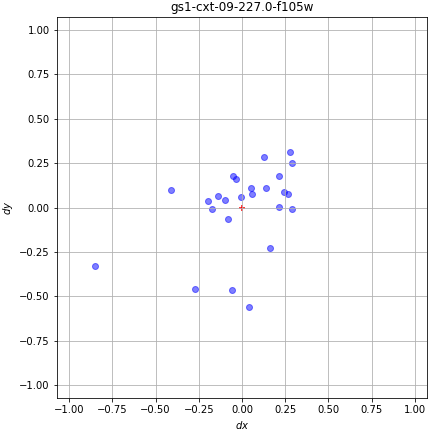

In [12]:
os.chdir(PATH_TO_PREP)
!cat gs1-cxt-09-227.0-f105w_wcs.log
Image(filename = PATH_TO_PREP + '/gs1-cxt-09-227.0-f105w_wcs.png', width = 600, height = 600)

## Grism sky subtraction

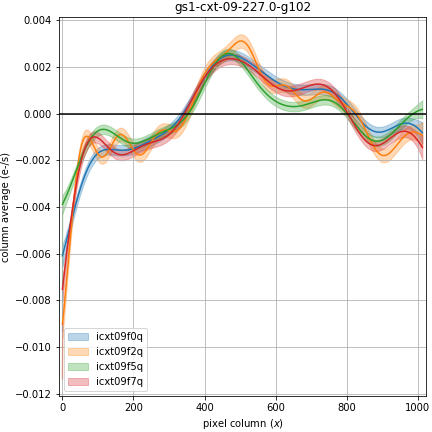

In [13]:
os.chdir(PATH_TO_PREP)
Image(filename = PATH_TO_PREP + '/gs1-cxt-09-227.0-g102_column.png', width = 600, height = 600)